# A Survey of Language Model Techniques

#### Last Time
In the [final notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11a_transfer_learning_my_reimplementation.ipynb?flush_cache=true) that focuses on computer vision applications, we showed how to implement from scratch all the pieces required to make transfer learning work. Specifically, we demonstrated how to pre-train an XResNet34 image classifier on a large imageset ([Imagewoof](https://github.com/fastai/imagenette)), and then slice off this model's head in order to obtain a bottleneck network. We then attached this bottleneck to a custom head that was tailor-made to classify the 37 categories of dog/cat breed images in the [Oxford-IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 

Along the way, we pointed out the most important pitfall to avoid when performing transfer learning: means and standard deviations in the bottleneck's pre-trained batchnorm layers should *never* be re-used when fine-tuning on a new dataset. Failure to heed this advice will significanty extend training time, and undo the time-saving benefit of transfer learning.

Ultimately, I found that using the pre-trained XResNet34 bottleneck with a custom head enabled me to train a classifier that achieved more than 80% validation accuracy on the Pets dataset after *only 8 epochs* of training. This turned out to be far, far superior to my attempt to train an XResNet34 model on the Pets dataset from scratch. After 5 epochs that model had only reached 25% validation accuracy.

#### Language Models
This will be the final PyTorch notebook in version 3 of the part II fast.ai course. We finally take a long-overdue respite from imagesets and turn our focus toward language models! We undertake a four part summary of tools for understanding text data that will introduce:
1. Techniques for pre-processing and batching text datasets.
2. Understanding and implementing [Stephen Merity's AWD-LSTM](https://arxiv.org/abs/1708.02182), which takes regular LSTM language models and turbo-charges them with a wide assortment of regularization techniques.
3. Pre-training a language model on Wikitext103.
4. Implementing [Jeremy Howard and Sebastian Ruder's ULMFiT](https://arxiv.org/abs/1801.06146) from scratch.

The working examples we create while exploring the ins and outs of deep learning text applications will all build toward the final goal of making a ULMFiT model that exhibits amazing performance when classifying IMDB movie reviews as either "positive" or "negative." The diagram below outlines the process necessary to make this goal a reality:

![Language Model Journey](images/language_model_steps.png)

## 1. Preprocessing and Properly Batching Text Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [2]:
#export
from exports.nb_11a import *

#### Loading the IMDB Dataset
We'll use the [IMDB Large Movie Review Dataset version 1.0](https://ai.stanford.edu/~amaas/data/sentiment/) for many the experiments we conduct in this notebook. It contains 50,000 labeled (as "positive" or as "negative") movie reviews, as well as 50,000 unlabelled reviews.

In [3]:
IMDB_URL = 'https://s3.amazonaws.com/fast-ai-nlp/imdb'

In [4]:
path = datasets.untar_data(IMDB_URL)

In [5]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb_classifier_processed.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/vocab_lm.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/ll_clas.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb_processed.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/ll_lm.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/ld.pkl')]

Recall that as we built fastai's datablock API from scratch in notebook 08, [we created](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb#ItemList-and-ImageList-classes) an `ItemList` class that kept track of file path of each item in a dataset. To help us manage images, we also created an `ImageList` class that inherited from `ItemList`, and helped us manage properties unique to image files, such as the image file extension type (.jpeg, .png, etc.). The `ImageList` class' `get()` method also used Pillow to open and display any of image files in a dataset.

Since we're now working with text data with special characteristics of its own, we'll once again subclass `ItemList`, and this time create a `TextList` class that is able to adequately manage and display the contents of text files.

In [5]:
#export
def read_file(fn):
    with open(fn, 'r', encoding = 'utf8') as f: return f.read()
    
class TextList(ItemList):
    @classmethod
    def from_files(cls, path, extensions='.txt', recurse=True, include=None, **kwargs):
        return cls(get_file_paths(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, i):
        if isinstance(i, Path): return read_file(i)
        return i

The IMDB movie review dataset's `train`, `test`, and `unsup` directories contain the text files that we'll be using. The 25,000 reviews in each of the train and test folders are labelled. The 50,000 reviews in the unsupervised folder are unlabelled.

In [7]:
text_list = TextList.from_files(path, include=['train', 'test', 'unsup'])

Let's verify that there is indeed a total of 100K text files, as we expect:

In [8]:
len(text_list.items)

100000

Let's get a feel for what one of our movie reviews looks like:

In [9]:
review = text_list[0]
review

"I didn't know what to expect when I started watching this movie, by the end of it I was pulling my hairs out. This was one of the most pathetic movies of this year...in fact, in the last ten years. David Dhawan should just give up his career as a director. I am yet to come across one original script that David Dhawan has worked on. This one was a complete bit y bit rip off Hitch. I have nothing against remakes as such, but this one is just so lousy that it makes you even hate the original one (which was pretty decent). I fail to understand what actors like Salman and Govinda saw in this script. I read somewhere, that this was supposed to be Govinda's comeback vehicle. If thats true, then only God can save his career. Salman just overacted to the hilt. Govinda who I think is an actor of very high caliber was completely wasted. Katrina Kaif and LAra Dutta had nothing to do apart form wearing designer clothes and smiling for no rhyme or reason. Please stay away form this one!"

#### Creating a validation set for a language model
When building a language model, we only set 10% of the texts aside to serve as a validation set.

In [10]:
split_data = SplitData.split_by_function(text_list, partial(random_splitter, p_valid=0.1))
split_data

SplitData
Train: TextList (89888 items)
[PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/6201_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/11881_2.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/11690_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/7300_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/2931_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/11165_4.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/1026_2.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/11499_3.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/3201_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/429_3.txt')...]
Path: /home/ubuntu/.fastai/data/imdb
Valid: TextList (10112 items)
[PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/8487_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/1684_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imdb/test/neg/3709_1.txt'), PosixPath('/home/ubuntu/.fastai/data/imd

#### Tokenization
The first preprocessing step for our text data is to tokenize it. All this does is take the text of each individual movie review and transform it into a list that contains the review's words, in the same order in which they appear in the original review. During this process we will also create tokens that represent certain punctuation, or syntax situations that commonly occur in English sentences. 

The [spaCy library](https://spacy.io/) has most of the tokenization rules we'll want to apply to our text dataset already built in to it. However, there are a few more customized rules that we'll first want to specify.

For example, we will place the tokens `xxbos` and `xxeos` (beginning/end of stream)at the beginning and end of each moview review. Their purpose is to tell the language model to reset its state. In other words, to let the model know that the subject matter/topic of the previous text document as ended, and everything that will soon follow will be related to different subject matter, such as a movie review for a different movie. Additionally, the token `xxup` is inserted before any word whose characters all appear in uppercase. Such a word's characters will then be converted to lowercase.

Why add in these custom tokenization rules at all? Why not just leave uppercase characters as uppercase? In practice we've found that including more aggressive tokenization rules ultimately leads to language models that are able to more accurately classify the sentiment of a block of text, and able to generate more natural, "believable" text.

Note that before we go in and apply tokenization to our text data, we'll first need to clean up some html code and other messy characters that tend to make their way into text datasets, such as our IMDB Large Movie Reviews, that have been scraped from internet sites. We'll need to clean up any snippets of raw html code or html renderings of characters, which were not originally part of the movie review texts. Examples include the "$" character being displayed as "#36;" as well as the html code for a line break, `<br />`.

A good general principle to keep in mind: the goal of preprocessing is to make it as easy as possible for our model to learn.

In [6]:
#export
import spacy, html

Here are the tokens that will be used by our custom tokenization rules:

In [7]:
#export

# Special tokens
UNK = "xxunk"
PAD = "xxpad"
BOS = "xxbos"
EOS = "xxeos"
TK_REP = "xxrep"
TK_WREP = "xxwrep"
TK_UP = "xxup"
TK_MAJ = "xxmaj"

default_special_tokens = [UNK, PAD, BOS, EOS, TK_REP, TK_WREP, TK_UP, TK_MAJ]

These clean-up and custom pre-tokenization rules will be applied *before* we run our text data through spaCy's tokenization process:

In [8]:
#export

# Clean up messy text:

def sub_br(t):
    """Replaces <br /> with \n"""
    re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
    return re_br.sub("\n", t)

def spec_add_spaces(t):
    """Add spaces around / and # characters"""
    return re.sub(r'([/#])', r' \1 ', t)

def rm_useless_spaces(t):
    """Replace two or more consecutive spaces with a single space"""
    return re.sub(' {2,}', ' ', t)

def fixup_text(x):
    """Various messy things Jeremy and Sylvain have seen in documents"""
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '\\"', '"').replace('<unk>', UNK).replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [9]:
#export

# Special pre-tokenization applied before spaCy:

def replace_rep(t):
    """
    Replace four or more repetitions of the same character.
    For example, "cccc" becomes "TK_REP 4 c"
    """
    def _replace_rep(m: Collection[str]) -> str:
        c, cc = m.groups()
        return f' {TK_REP} {len(cc) + 1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

def replace_wrep(t):
    """
    Replace four or more repetitions of the same word.
    For example, "word word word" becomes "TK_WREP 3 word"
    """
    def _replace_wrep(m: Collection[str]) -> str:
        c, cc = m.groups()
        return f' {TK_WREP} {len(cc.split()) + 1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

default_pre_rules = [sub_br, spec_add_spaces, rm_useless_spaces, 
                     fixup_text, replace_rep, replace_wrep]

Let's make sure each of the above six clean-up / pre-tokenization steps work as expected:

In [15]:
print(sub_br("This is a <br /> sample sentence."))

This is a 
 sample sentence.


In [16]:
spec_add_spaces("This is /a s#ample sentence.")

'This is  / a s # ample sentence.'

In [17]:
rm_useless_spaces("This is a    sample  sentence.")

'This is a sample sentence.'

In [18]:
print(fixup_text('This#39; amp;is#146; nbsp;a#36; \\nsamplequot; \\"sentence<unk>  @.@ and @-@ \\that is all.'))

This' &is' a$ 
sample' "sentencexxunk .and- \ that is all.


In [19]:
replace_rep('cccc')

' xxrep 4 c '

In [20]:
replace_wrep('word word word word ')

' xxwrep 4 word  '

Why would we prefer to replace repeating characters or words with "counter" tokens? Most often, there isn't any significance in a word or character being repeated 4 times versus being repeated, say, 5 times. What is, instead, significant is a word or character being repeated just a handful of times, versus being repeated a very large number, say 28, times. Using counter-style tokens will make it easier for our language model to learn that the *magnitude* by which a certain character or word is repeated, is what most strongly influences meaning.

For example, what if we were to instead create a unique token every time the same character, such as an exclamation point, is repeated at a new length? E.g. we would have one token to represent 27 exclamation points, another token to represent 28 exclamations, and another to represent 3, and so on and so forth. In this case, even if the corpus contains many examples of exclamation points being repeated successive times, unless repeated exclamation points occur in each of the above sequence lengths often enough, it is unlikely that our model will learn the truth about exclamation points: a lot of them at once add a lot of emphasis.

More likely, our model might incorrectly learn that 28 exclamation points in a row adds emphasis, but that 27 exclamation points in a row has no special meaning at all!

Alternatively, we could create an individual token for each exclamation point. While this would conceivable make it easier for our LSTM model to learn that many exclamation points = big emphasis, it will at the same time require the model to have to maintain quite a long memory of previous states (28 steps previous) in order to learn what it needs to learn about long sequences of exclamation points. Capturing all this information in one single token makes it much easier for our model to learn!

Let's move on to post-tokenization: in addition to the above pre-tokenization rules, the following three custom post-tokenization rules will be applied *after* spaCy tokenization is run. They are applied after tokenization because they change things at the word-level.

In [10]:
#export

# Special tokenization applied after spaCy:

def replace_all_caps(x):
    """
    Replace tokens composed of all uppercase characters with lowercase,
    and insert the token `TK_UP` so that it directly precedes the now
    uppercase token.
    """
    result = []
    for t in x:
        if t.isupper() and len(t) > 1: 
            result.append(TK_UP)
            result.append(t.lower())
        else: result.append(t)
    return result

def replace_capitalized(x):
    """
    Replaces any capitalized tokens (words where the first character only is
    uppercase) with an uncapitalized version, and inserts the token `TK_MAJ` so
    that it directly now precedes the now uncapitalized token.
    """
    result = []
    for t in x:
        if t == '': continue
        if t[0].isupper() and len(t) > 1 and t[1:].islower(): result.append(TK_MAJ)
        result.append(t.lower())
    return result

def add_eos_bos(x):
    """
    Adds the `BOS` and `EOS` tokens at the beginning and end, respectively, 
    of each stream/list (previously an individual movie review) of tokens.
    """
    return [BOS] + x + [EOS]

default_post_rules = [replace_all_caps, replace_capitalized, add_eos_bos]

Let's test out our three custom post-tokenization rules:

In [22]:
replace_all_caps(['I', 'AM', 'SHOUTING'])

['I', 'xxup', 'am', 'xxup', 'shouting']

In [23]:
replace_capitalized(['Hi', 'my', 'name', 'is', 'James'])

['xxmaj', 'hi', 'my', 'name', 'is', 'xxmaj', 'james']

In [24]:
add_eos_bos(['This', 'was', 'a', 'complete', 'sentence'])

['xxbos', 'This', 'was', 'a', 'complete', 'sentence', 'xxeos']

All this text clean-up, and tokenization will go a lot faster if we can parallelize them. A `ProcessPoolExecutor` will help us do this:

In [11]:
#export

from spacy.symbols import ORTH
from concurrent.futures import ProcessPoolExecutor

def parallel(func, arr, max_workers=4):
    if max_workers < 2: 
        results = list(progress_bar(map(func, enumerate(arr)), total=len(arr)))
    else:
        with ProcessPoolExecutor(max_workers = max_workers) as ex:
            return list(progress_bar(ex.map(func, enumerate(arr)), total=len(arr)))
    if any([o is not None for o in results]): return results

Now we implement the `TokenizeProcessor` class that will convert our movie review dataset's text reviews into lists containing tokens. It inherits from the `Processor` class we defined [back in notebook 08](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb#4.--Labeling). It will also leverage the above `parallel` method to speed things up:

In [12]:
#export

class TokenizeProcessor(Processor):
    def __init__(self, lang='en', chunksize=2000, pre_rules=None, post_rules=None, max_workers=4):
        self.chunksize, self.max_workers = chunksize, max_workers
        # Use spaCy's default tokenizing rules.
        self.tokenizer = spacy.blank(lang).tokenizer 
        # And add a few special ones of our own to take place 
        # before and after spaCy is run.
        for w in default_special_tokens:
            self.tokenizer.add_special_case(w, [{ORTH: w}])
        self.pre_rules  = default_pre_rules if pre_rules is None else pre_rules
        self.post_rules = default_post_rules if post_rules is None else post_rules
        
    def process_chunk(self, args):
        i, chunk = args
        chunk = [apply_transforms(t, self.pre_rules) for t in chunk]
        docs = [[d.text for d in doc] for doc in self.tokenizer.pipe(chunk)]
        docs = [apply_transforms(t, self.post_rules) for t in docs]
        return docs
    
    def __call__(self, items):
        tokens = []
        if isinstance(items[0], Path): items = [read_file(i) for i in items]
        chunks = [items[i: i + self.chunksize] for i in (range(0, len(items), self.chunksize))]
        tokens = parallel(self.process_chunk, chunks, max_workers=self.max_workers)
        return sum(tokens, [])
    
    def process_one_item(self, item): return self.process_chunk([tokens])[0]
    
    def deprocess(self, tokens): return [self.deprocess_one_item(token) for token in tokens]
    
    def deprocess_one_item(self, token): return " ".join(token)

Now let's test out `TokenizeProcessor` using the first 100 movie reviews:

In [27]:
tp = TokenizeProcessor()
tokenized = tp(text_list[:100])

In [28]:
len(tokenized)

100

In [29]:
tokenized[0][:20]

['xxbos',
 'i',
 'did',
 "n't",
 'know',
 'what',
 'to',
 'expect',
 'when',
 'i',
 'started',
 'watching',
 'this',
 'movie',
 ',',
 'by',
 'the',
 'end',
 'of',
 'it']

#### Numericalization
The second text pre-processing step is to replace each token in our lists of movie reviews with a unique integer number. Each token, in whichever movie reviews it appears, will always be associated with the same integer number. 

Why do we do this? Recall that for computer vision applications, the jpeg image inputs we work with are nothing more than three-channel tensors full of byte values, which are then converted to floats. Recall also that deep neural networks are nothing more than a succession of affine transforms of the pattern $y = mx + b$. We can't feed letters (or colors, for that matter) *themselves* as inputs into this equation, but we can feed in numbers. 

As long as we have a way to map distinct numbers to the words they represent, our model will be able to process these lists of numbers, which were formerly lists of words, and learn about distinct meanings and interrelationships of the various words in a text dataset.

We'll thus create another Processor class called `NumericalizeProcessor` to accomplish this. Since this class' job will be to create a mapping of numbers to individual words, and then replace word the tokens with these numbers, it will work in a manner very similar to the [`Category Processor` class](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb#4.--Labeling) we previously built to create and maintain a list integer labels for the various categories of multi-class datasets.

#### `NumericalizeProcessor` class - one other wrinkle
My initial implementation of this class did not strictly ensure that the numericalized vocabulary would be no longer than the value passed to the class' `max_vocab` argument. This oversight became a problem because tokenizing and numericalizing the WikiText 103 text corpus produced a vocabulary of length `60,001`, while my first attempts to do the same for the IMDB movie reviews happend to produce a vocab that had `60,002` words. It would turn out that in order to pre-train a language model on WikiText 103 and then fine-tune using the IMDB movie reviews corpus, I would need to ensure that both textsets had vocab lists that were identical in length.

What happened was that after a `NumericalizeProcessor()` object creates its vocab list, the following logic was used to ensure that all of the default special tokens, such as `PAD`, `UNK`, etc., were placed at the beginning of the vocab:

```
for o in reversed(default_special_tokens):
    if o in self.vocab: self.vocab.remove(o)
    self.vocab.insert(0, o)
```

What this logic didn't take into account was cases when there would be some tokens in `default_special_tokens` that didn't otherwise appear in the vocab for the corpus that was generated inside a `NumericalizeProcessor()` object. For example, we would never expect the padding token to already be inside a tokenized vocabulary. However, we nonetheless need it inside our vocabulary because it will absolutely be part of text sampled fed as inputs to our model should we ever desire to perform classification tasks.

Furthermore, even if other default special tokens aren't originally part of our vocabulary, we still ultimately need to have them inside it. Why? Well, say that our original training and validation text sets don't contain a single occurrence of the `UNK` token. After training our model, if we perform inference on some new text that has some strange html artifacts such as `'<unk>'`, we will need to replace those occurrences with the `UNK` token. But if our model doesn't have a vocabulary embedding for this token, we won't be able to perform this relacement, and it's possible that our model's ability to perform inference would be diminished.

It thus became clear to me that after inserting all the default special tokens, I would need to clip any words off the end of the vocab list, so that it's maximum cap wasn't exceeded. Here's the logic I used:

```
if len(self.vocab) > self.max_vocab:
    self.vocab = self.vocab[:self.max_vocab]
```

In [13]:
#export

import collections

class NumericalizeProcessor(Processor):
    def __init__(self, vocab=None, max_vocab=60000, min_freq=2):
        self.vocab, self.max_vocab, self.min_freq = vocab, max_vocab, min_freq
        
    def __call__(self, items):
        # The overall vocab is defined on first use.
        if self.vocab is None:
            freq = Counter(p for o in items for p in o)
            self.vocab = [o for o, c in freq.most_common(self.max_vocab) if c >= self.min_freq]
            for o in reversed(default_special_tokens):
                if o in self.vocab: self.vocab.remove(o)
                self.vocab.insert(0, o)
                
            # Ensure max_vocab not exceeded:
            if len(self.vocab) > self.max_vocab:
                self.vocab = self.vocab[:self.max_vocab]
                
        if getattr(self, 'otoi', None) is None:
            # Create mapping of each vocab item to an index
            # Note: 'otoi' means "object to int"
            self.otoi = collections.defaultdict(int, {v: k for k, v in enumerate(self.vocab)})
        return [self.process_one_item(o) for o in items]
    
    def process_one_item(self, item): return [self.otoi[o] for o in item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deprocess_one_item(idx) for idx in idxs]
    
    def deprocess_one_item(self, idx): return [self.vocab[i] for i in idx]

Let's test it out:

In [31]:
np = NumericalizeProcessor()

In [32]:
numericalized = np(tokenized)

In [33]:
numericalized[0][:20]

[2,
 17,
 90,
 31,
 145,
 61,
 14,
 523,
 84,
 17,
 1124,
 129,
 18,
 29,
 10,
 56,
 8,
 165,
 11,
 16]

Now we'll tokenize and numericalize the entire IMDB movie review corpus and store inside a `LabelList()` object. When training on text we don't need an explicit list of `y` labels because we can always use our numericalizer's mappings to infer the original words of movie reviews from their numericalized versions. Note, however, that in order to store our data as a `LabelList` and then inside a `DataBunch`, from which training data will be fed into a model, we need to create a dummy list of labels so that our training loop, as architected, can still run.

In [34]:
tokenizer = TokenizeProcessor(max_workers=8)
numericalizer = NumericalizeProcessor()

In [35]:
%time label_list = label_by_function(split_data, func = lambda y: 0, x_processor = [tokenizer, numericalizer]) 

CPU times: user 25.2 s, sys: 3.1 s, total: 28.3 s
Wall time: 2min 40s


To convert any of our numericalized movie reviews back to their original words, we can use `x_obj`:

In [36]:
label_list.train.x_obj

<bound method LabeledData.x_obj of LabeledData
x: TextList (89888 items)
[[2, 18, 87, 35, 140, 64, 14, 535, 68, 18, 685, 169, 19, 29, 10, 47, 8, 148, 13, 16, 18, 25, 3812, 77, 15036, 61, 9, 7, 19, 25, 43, 13, 8, 110, 1154, 118, 13, 19, 340, 92, 17, 211, 10, 17, 8, 248, 728, 174, 9, 7, 607, 7, 22106, 156, 57, 221, 72, 40, 626, 26, 12, 170, 9, 18, 259, 256, 14, 234, 615, 43, 231, 246, 20, 7, 607, 7, 22106, 60, 937, 34, 9, 7, 19, 43, 25, 12, 616, 244, 4652, 244, 1556, 142, 7, 4653, 9, 18, 41, 178, 466, 5736, 26, 160, 10, 30, 19, 43, 15, 57, 52, 2361, 20, 16, 180, 32, 76, 735, 8, 231, 43, 36, 79, 25, 206, 549, 33, 9, 18, 1969, 14, 407, 64, 171, 53, 7, 6161, 11, 7, 10827, 235, 17, 19, 246, 9, 18, 371, 1265, 10, 20, 19, 25, 457, 14, 42, 7, 10827, 22, 6915, 2268, 9, 7, 63, 20, 862, 316, 10, 115, 81, 7, 559, 78, 600, 40, 626, 9, 7, 6161, 57, 10685, 14, 8, 12320, 9, 7, 10827, 49, 18, 122, 15, 48, 304, 13, 70, 324, 5606, 25, 355, 1022, 9, 7, 13453, 7, 33296, 11, 10393, 7, 21302, 85, 178, 14, 58,

In [37]:
label_list.train.x_obj(0)

"xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very high caliber was completely wasted . xxmaj katrina xxmaj kaif and lara xxmaj dutta ha

Since it takes a few minutes to process our text corpus, it'll be useful to save the processed output using pickle. Caution: never use lambdas in processors, cause lambdas don't pickle properly.

In [38]:
pickle.dump(label_list, open(path/'imdb_processed.pkl', 'wb'))

In [39]:
label_list = pickle.load(open(path/'imdb_processed.pkl', 'rb'))

#### Batching for Language Model Training
If you're used to training image classifier models, batching for language model training can seem a bit counterintuitive at first. One thing we *don't* want in this scenario is to feed our model batches of discrete IMDB reviews. Rather, seeing as how we want our model to simply learn the *language* that's used to compose IMDB reviews, there's no need to break out each individual review; we can just concatenate all the review texts together and feed this *stream* into our model.

To accomplish this, we'll create a special langauge model dataset to shuffle (if we want) and then concatenate the movie reviews into one big list of tokens. The dataset then divides this long list into into `batch_size` number of equal length chunks. 

These per-batch chunks will be further subdivided into even smaller sequences that are processed in parallel by our model during training. The length of these smaller sequences is the number of words each mini-batch of our model will be responsible for looking at during any single training iteration. We get to choose how many words we want this to be, though 70 is a nice standard. Our model will attempt to learn how to predict the most appropriate word that should follow each of the (70, for example) individual words that are inside each these smaller sequences.

In other words, these small sequences are essentially the individual training inputs that our model will train on in order to learn how to understand and generate language. The length we choose for these small sequences is the distance that an LSTM model will "backpropagate through time" (often shortened to `bptt`) in order to learn how to predict the subsequent word that should follow each word in a given input word sequence.

Here's an illustration of how the whole batching process for training language models works. Say we have the following stream of text concatenated together by our language model dataset:

In [40]:
from IPython.display import display, HTML
import pandas as pd

stream = '''
In this notebook, we will go back over the example of classifying movie reviews we studied in part I, and dig deeper under the surface. 
First we will look at the processing steps necessary to convert test into numbers and how to customize it. By doing this we'll have another example of the Processor used in the DataBlock API. 
Then we will study how we build a language model and train it.\n
'''
test_tokenizer = TokenizeProcessor(max_workers=8)
tokens = np.array(test_tokenizer([stream])[0])
print(f'Number of tokens: {len(tokens)}')
tokens

Number of tokens: 91


array(['xxbos', '\n', 'xxmaj', 'in', ..., 'it', '.', '\n\n', 'xxeos'], dtype='<U11')

Let's say we choose to have 6 batches. How do we split up our corpus between these six batches, so that we can train on all of it during one epoch?

We need to figure out the total length (number of words/tokens in the text, and divide this by the number of batches. That'll tell us how many words/tokens each of the six batches needs to handle, so that we can be sure we train over the entire text during one epoch.

In [41]:
bs = 6
# Total number of batches needed to complete one training epoch.
# Aka: also the number of words/tokens that each batch will manage.
chunk_size = len(tokens) // bs 
chunk_size

15

And if we have 6 batches and use a chunk size of 15 words, here's how we'd split the corpus up between each of the six batches:

In [42]:
batch_tokens = np.array([tokens[i*chunk_size: (i+1)*chunk_size] for i in range(bs)])
df = pd.DataFrame(batch_tokens, columns=[f'Word {i}' for i in range(chunk_size)]).set_index(pd.Index([f'Batch {i}' for i in range(bs)]))
display(HTML(df.to_html()))

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Batch 0,xxbos,\n,xxmaj,in,this,notebook,",",we,will,go,back,over,the,example,of
Batch 1,classifying,movie,reviews,we,studied,in,part,i,",",and,dig,deeper,under,the,surface
Batch 2,.,\n,xxmaj,first,we,will,look,at,the,processing,steps,necessary,to,convert,test
Batch 3,into,numbers,and,how,to,customize,it,.,xxmaj,by,doing,this,we,'ll,have
Batch 4,another,example,of,the,xxmaj,processor,used,in,the,datablock,xxup,api,.,\n,xxmaj
Batch 5,then,we,will,study,how,we,build,a,language,model,and,train,it,.,\n\n


However, depending on the length of our backpropagation-through-time (`bptt`) value, we likely won't train on each batch's 15 words during one iteration. Instead, we'll split training into a number of iterations which equals total batch sequence length (or chunk size) divided by the `bptt` value.

In our case, if we choose a `bptt` length of 5, it would then take three iterations to train the sequence length (or chunk size) of the 15 tokens/words that belong to each batch:

In [43]:
bptt = 5
for k in range(chunk_size//bptt):
    batch_tokens = np.array([tokens[i*chunk_size + k*bptt: i*chunk_size + (k+1)*bptt] for i in range(bs)])
    print(f'Iteration {k}')
    df = pd.DataFrame(batch_tokens, columns=[f'Word {i+k*bptt}' for i in range(bptt)]).set_index(pd.Index([f'Batch {i}' for i in range(bs)]))
    display(HTML(df.to_html()))

Iteration 0


,Word 0,Word 1,Word 2,Word 3,Word 4
Batch 0,xxbos,\n,xxmaj,in,this
Batch 1,classifying,movie,reviews,we,studied
Batch 2,.,\n,xxmaj,first,we
Batch 3,into,numbers,and,how,to
Batch 4,another,example,of,the,xxmaj
Batch 5,then,we,will,study,how


Iteration 1


,Word 5,Word 6,Word 7,Word 8,Word 9
Batch 0,notebook,",",we,will,go
Batch 1,in,part,i,",",and
Batch 2,will,look,at,the,processing
Batch 3,customize,it,.,xxmaj,by
Batch 4,processor,used,in,the,datablock
Batch 5,we,build,a,language,model


Iteration 2


,Word 10,Word 11,Word 12,Word 13,Word 14
Batch 0,back,over,the,example,of
Batch 1,dig,deeper,under,the,surface
Batch 2,steps,necessary,to,convert,test
Batch 3,doing,this,we,'ll,have
Batch 4,xxup,api,.,\n,xxmaj
Batch 5,and,train,it,.,\n\n


It's crucial that each batch (0, 1, 2, ..., 5) draw from the same sequences of text from one iteration to the next. In iteration 0, batch 0 will help the model develop some state concerning the text `"xxbos	\n	xxmaj	in	this"`. If the text that batch 0 sees in iteration 1 isn't the text that originally follows these five words in the original corpus, then all that state that the model went to the effort of learning in iteration 0 will have been wasted.

Let's implement the language model dataset class, which we'll call `LM_Dataset`. When creating the language model dataloader, we'll pass an `LM_Dataset()` object directly to the `dataset` argument of PyTorch's [`DataLoader` class](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [14]:
#export

class LM_Dataset():
    def __init__(self, data, bs=64, bptt=70, shuffle=False):
        self.data, self.bs, self.bptt, self.shuffle = data, bs, bptt, shuffle
        corpus_len = sum([len(t) for t in data.x]) # Number words/tokens in the training set
        self.per_batch_chunk_size = corpus_len // bs
        self.batchify()
 
    # The length of the dataset. Specifically, the total number of 
    # bptt sequences that will be processed by all batches across 
    # all training iterations.
    #
    # Why subtract 1 from each batch's total chunk of the corpus? 
    # This is to ensure that the final input token seen by each 
    # batch at end of the final iteration has a corresponding target 
    # to predict!
    def __len__(self): return ((self.per_batch_chunk_size - 1) // self.bptt) * self.bs

    def __getitem__(self, idx):
        source = self.batched_data[idx % self.bs]
        seq_idx = (idx // self.bs) * self.bptt
        # Return a tuple of: 
        # 1. Inputs: <bs> number of batches, each containing 
        #            <bptt> tokens.
        # 2. Targets: Same shape and tokens as inputs, but 
        #             advances each token's index by one.
        #             For a token at a given index in an input 
        #             bptt sequence, the corresponding target 
        #             needs to be the word in the corpus text 
        #             that comes next.
        return source[seq_idx: seq_idx + self.bptt], source[seq_idx + 1: seq_idx + self.bptt + 1]
    
    def batchify(self):
        texts = self.data.x
        if self.shuffle: texts = texts[torch.randperm(len(texts))]
        stream = torch.cat([tensor(t) for t in texts])
        self.batched_data = stream[:self.per_batch_chunk_size * self.bs].view(self.bs, self.per_batch_chunk_size)

Let's re-run the 6 batch example on the sample text stream we just worked with above, this time making use of the `LM_Dataset` class.

Recall that we've already converted the text stream into a list of 91 tokens:

In [45]:
print(tokens)
print(len(tokens))

['xxbos' '\n' 'xxmaj' 'in' ... 'it' '.' '\n\n' 'xxeos']
91


The next step is to use the `NumericalizeProcessor` class to convert each vocabulary word to its corresponding number:

In [46]:
test_numericalizer = NumericalizeProcessor(min_freq=1)
numericalized = test_numericalizer([tokens])

This is the numericalized version of our text stream:

In [47]:
print(numericalized)

[[2, 11, 7, 12, 15, 22, 16, 8, 13, 23, 24, 25, 9, 17, 18, 26, 27, 28, 8, 29, 12, 30, 31, 16, 14, 32, 33, 34, 9, 35, 10, 11, 7, 36, 8, 13, 37, 38, 9, 39, 40, 41, 19, 42, 43, 44, 45, 14, 20, 19, 46, 21, 10, 7, 47, 48, 15, 8, 49, 50, 51, 17, 18, 9, 7, 52, 53, 12, 9, 54, 6, 55, 10, 11, 7, 56, 8, 13, 57, 20, 8, 58, 59, 60, 61, 14, 62, 21, 10, 63, 3]]


In [48]:
len(numericalized[0])

91

And here's a dummy class whose only job is to get our numericalized text stream into the format that `LM_Dataset` expects -- namely, to store the list of numericalized text inside an object under an attribute called `x`.

In [49]:
class Test_Text_Data():
    def __init__(self, numericalized_input):
        self.x = numericalized_input
        
    def __getitem__(self):
        return self
    
test_text = Test_Text_Data(numericalized)

In [50]:
lm_dataset = LM_Dataset(test_text, bs=bs, bptt=bptt)

In [51]:
test_dl = DataLoader(lm_dataset, batch_size=bs)
iter_dl = iter(test_dl)

In [52]:
iteration0, targets0 = next(iter_dl)
iteration0

tensor([[ 2, 11,  7, 12, 15],
        [26, 27, 28,  8, 29],
        [10, 11,  7, 36,  8],
        [44, 45, 14, 20, 19],
        [51, 17, 18,  9,  7],
        [56,  8, 13, 57, 20]])

In [53]:
targets0

tensor([[11,  7, 12, 15, 22],
        [27, 28,  8, 29, 12],
        [11,  7, 36,  8, 13],
        [45, 14, 20, 19, 46],
        [17, 18,  9,  7, 52],
        [ 8, 13, 57, 20,  8]])

In [54]:
test_numericalizer.deprocess(iteration0)

[['xxbos', '\n', 'xxmaj', 'in', 'this'],
 ['classifying', 'movie', 'reviews', 'we', 'studied'],
 ['.', '\n', 'xxmaj', 'first', 'we'],
 ['into', 'numbers', 'and', 'how', 'to'],
 ['another', 'example', 'of', 'the', 'xxmaj'],
 ['then', 'we', 'will', 'study', 'how']]

In [55]:
test_numericalizer.deprocess(targets0)

[['\n', 'xxmaj', 'in', 'this', 'notebook'],
 ['movie', 'reviews', 'we', 'studied', 'in'],
 ['\n', 'xxmaj', 'first', 'we', 'will'],
 ['numbers', 'and', 'how', 'to', 'customize'],
 ['example', 'of', 'the', 'xxmaj', 'processor'],
 ['we', 'will', 'study', 'how', 'we']]

In [56]:
iteration1, targets1 = next(iter_dl)
iteration1

tensor([[22, 16,  8, 13, 23],
        [12, 30, 31, 16, 14],
        [13, 37, 38,  9, 39],
        [46, 21, 10,  7, 47],
        [52, 53, 12,  9, 54],
        [ 8, 58, 59, 60, 61]])

In [57]:
targets1

tensor([[16,  8, 13, 23, 24],
        [30, 31, 16, 14, 32],
        [37, 38,  9, 39, 40],
        [21, 10,  7, 47, 48],
        [53, 12,  9, 54,  6],
        [58, 59, 60, 61, 14]])

In [58]:
test_numericalizer.deprocess(iteration1)

[['notebook', ',', 'we', 'will', 'go'],
 ['in', 'part', 'i', ',', 'and'],
 ['will', 'look', 'at', 'the', 'processing'],
 ['customize', 'it', '.', 'xxmaj', 'by'],
 ['processor', 'used', 'in', 'the', 'datablock'],
 ['we', 'build', 'a', 'language', 'model']]

In [59]:
test_numericalizer.deprocess(targets1)

[[',', 'we', 'will', 'go', 'back'],
 ['part', 'i', ',', 'and', 'dig'],
 ['look', 'at', 'the', 'processing', 'steps'],
 ['it', '.', 'xxmaj', 'by', 'doing'],
 ['used', 'in', 'the', 'datablock', 'xxup'],
 ['build', 'a', 'language', 'model', 'and']]

We can see that when using `LM_Dataset`, our dataloader only returns two iterations of batches:

In [60]:
iter_dl = iter(test_dl)
all_iterations = list(enumerate(iter_dl))
last_iteration = all_iterations[-1]

In [61]:
last_iteration

(1, [tensor([[22, 16,  8, 13, 23],
          [12, 30, 31, 16, 14],
          [13, 37, 38,  9, 39],
          [46, 21, 10,  7, 47],
          [52, 53, 12,  9, 54],
          [ 8, 58, 59, 60, 61]]), tensor([[16,  8, 13, 23, 24],
          [30, 31, 16, 14, 32],
          [37, 38,  9, 39, 40],
          [21, 10,  7, 47, 48],
          [53, 12,  9, 54,  6],
          [58, 59, 60, 61, 14]])])

This demonstrates that the dataloader's final iteration is indeed `iteration1`, which is the second of the two iterations of batches that our dataloader returns. In our first crack at this toy example using Pandas above, we were able to generate three iterations of six batches that each had five-word sequences. Why doesn't our dataloader do that for us here?

The reason is: in that example we didn't have to worry about making sure that each word in each batch's `bptt` sequences had a corresponding target to predict!

The target for each word in the input sequence is the word that originally followed it in the text. We have to ensure that we batch our dataset in such a way that each word that goes into our model as training inputs will have one word in the corpus that directly follows it. This means that there will always be at least one word in our training set that serves as a target alone, and doesn't get trained on.

Recall that we have a sample corpus containing 91 tokens with a batch size of 6 and a bptt length of 5. Dividing 91 by 6 gives 15 with a remainder of 1. Why can't we have a sequence of 15 for each of the 6 batches? (Indeed, doing so would have us training over 3 iterations.) Well, if we did this, once we got to the epoch's third and final iteration, only the last word in the bptt sequence of batch0 would have a target to predict (remember, dividing 91 by 6 has a remainder of *only* 1). There would be no targets for the final word of the final iteration for the other five batches.

From this thought exercise we can see that the actual per-batch sequence length will be long enough so that we can train the maximum number of iterations (fit as many bptt sequences as possible into each batch's sequence of words), while still ensuring that there will be at least one word left over to serve as the final prediction target word for each batch at the end of the final iteration.

Let's test it our on a subset of the IMDB movie review data. For this illustration, we're only going to use the texts found in the IMDB review dataset's 'test' folder. 

First off, here are the total number of documents that will be served by the dataloader:

In [62]:
num_documents = len(label_list.valid.x)
num_documents

10112

Here's the total combined length of all texts in this corpus:

In [63]:
corpus_length = sum([len(t) for t in label_list.valid.x])
corpus_length

3066113

Here's the batch size and `bptt` length we'll use:

In [64]:
bs = 64
bptt = 70

Across all iterations, each batch will train on chunks of text that are this long:

In [65]:
per_batch_chunk_size = corpus_length // bs
per_batch_train_chunk_size = per_batch_chunk_size - 1
per_batch_train_chunk_size

47907

Remember, we subtract one from each batch's chunk of text in order to ensure that each token at a given index of each input bptt sequence has a corresponding target to predict. This target needs to be the word in the corpus text that originally came after the input word. At the end of the final iteration, the final word of each batch's training targets will be a word that *didn't* get trained on.

Here is what we expect to be the length of the language model dataset. It's the the total number of bptt sequences that will be processed by all batches across all training iterations.

In [66]:
dataset_length = (per_batch_train_chunk_size // bptt) * bs
dataset_length

43776

Finally, we expect there to be this many iterations returned by the dataloader during one epoch:

In [67]:
dataset_length // bs

684

So, let's give it a try and see if the dataloader behaves the way we expect:

In [68]:
dl = DataLoader(LM_Dataset(label_list.valid, shuffle=True, bs=bs, bptt=bptt), batch_size=bs)

In [69]:
iter_dl = iter(dl)
batches = list(enumerate(iter_dl))
len(batches)

684

In [70]:
iter_dl = iter(dl)
x1, y1 = next(iter_dl)
x2, y2 = next(iter_dl)

In [71]:
x1.size(), y1.size()

(torch.Size([64, 70]), torch.Size([64, 70]))

In [72]:
print(numericalizer.deprocess(x1)[0])

['xxbos', 'xxmaj', 'with', 'such', 'a', 'cool', '-', 'looking', 'xxup', 'dvd', 'jacket', ',', '2', 'well', '-', 'known', 'actors', '(', 'xxmaj', 'vinnie', 'xxmaj', 'jones', 'and', 'xxmaj', 'sean', 'xxmaj', 'astin', ')', ',', 'and', 'a', 'cool', 'premise', '(', 'time', 'travel', 'and', 'a', 'bank', 'robbery', ')', ',', 'i', 'expected', 'something', 'similar', 'to', 'xxmaj', 'nick', 'xxmaj', 'cage', "'s", '"', 'xxmaj', 'next', '"', ',', 'but', 'different', '.', '\n\n', 'xxmaj', 'instead', ',', 'we', 'get', 'a', 'film', 'that', 'thinks']


In [73]:
print(numericalizer.deprocess(y1)[0])

['xxmaj', 'with', 'such', 'a', 'cool', '-', 'looking', 'xxup', 'dvd', 'jacket', ',', '2', 'well', '-', 'known', 'actors', '(', 'xxmaj', 'vinnie', 'xxmaj', 'jones', 'and', 'xxmaj', 'sean', 'xxmaj', 'astin', ')', ',', 'and', 'a', 'cool', 'premise', '(', 'time', 'travel', 'and', 'a', 'bank', 'robbery', ')', ',', 'i', 'expected', 'something', 'similar', 'to', 'xxmaj', 'nick', 'xxmaj', 'cage', "'s", '"', 'xxmaj', 'next', '"', ',', 'but', 'different', '.', '\n\n', 'xxmaj', 'instead', ',', 'we', 'get', 'a', 'film', 'that', 'thinks', 'it']


In [74]:
print(numericalizer.deprocess(x2)[0])

['it', 'is', 'like', 'the', '"', 'xxmaj', 'matrix', '"', 'with', 'rotating', 'camera', 'slow', '-', 'mo', 'gun', 'battles', '(', 'where', 'nobody', 'takes', 'cover', ')', ',', 'unbelievable', 'dialog', 'and', 'bad', 'casting', '(', 'the', 'male', 'xxup', 'fbi', 'partner', 'looked', 'like', 'he', 'just', 'came', 'from', 'a', 'soap', 'commercial', ',', 'and', 'xxmaj', 'sean', 'xxmaj', 'astin', 'can', 'not', 'cut', 'it', 'as', 'a', '"', 'genius', '"', 'scientist', ')', '.', '\n\n', 'xxmaj', 'the', 'only', 'one', 'who', 'saves', 'face', 'is']


In [75]:
print(numericalizer.deprocess(y2)[0])

['is', 'like', 'the', '"', 'xxmaj', 'matrix', '"', 'with', 'rotating', 'camera', 'slow', '-', 'mo', 'gun', 'battles', '(', 'where', 'nobody', 'takes', 'cover', ')', ',', 'unbelievable', 'dialog', 'and', 'bad', 'casting', '(', 'the', 'male', 'xxup', 'fbi', 'partner', 'looked', 'like', 'he', 'just', 'came', 'from', 'a', 'soap', 'commercial', ',', 'and', 'xxmaj', 'sean', 'xxmaj', 'astin', 'can', 'not', 'cut', 'it', 'as', 'a', '"', 'genius', '"', 'scientist', ')', '.', '\n\n', 'xxmaj', 'the', 'only', 'one', 'who', 'saves', 'face', 'is', 'xxmaj']


Looks great! `x1` contains the first iteration of 70 tokens for each of the 64 batches. `y1` contains the corresponding targets for each batch's input tokens. We verified that the targets (`y1[0]`) for the first batch (`x1[0]`) are the first batch's words, but shifted one position to the right.

We also can see that the same sequences of text are processed by each batch across all iterations. The text sequence seen by the first batch during the second iteration, `x2[0]`, directly follows the text sequence seen by the first batch during the first iteration, `x1[0]`! 

Let's also see if our dataloader returns 670 iterations of batches, per epoch:

In [76]:
iter_dl = iter(dl)
batches = list(enumerate(iter_dl))
len(batches)

684

Just to be complete, let's also double check that the final batch is the size and content we'd expect. We'll ensure that the final training token in the final batch does, indeed, have the correct target word associate with it:

In [77]:
iter_dl = iter(dl)
batches = list(enumerate(iter_dl))
last_batch = batches[-1]
x670, y670 = last_batch[1][0], last_batch[1][1]

In [78]:
x670.size(), y670.size()

(torch.Size([64, 70]), torch.Size([64, 70]))

In [79]:
print(numericalizer.deprocess(x670)[63])

['hour', 'and', '20', 'minutes', 'of', 'my', 'entire', 'life', '.', '\n\n', 'xxmaj', 'beware', 'this', 'movie', 'unless', 'you', 'really', 'want', 'to', 'waste', 'your', 'money', 'on', 'it', '.', 'xxmaj', 'even', 'with', 'all', 'the', 'big', 'name', 'actors', '/', 'actress', 'it', 'was', 'done', 'rather', 'poorly', '.', 'xxmaj', 'shaky', 'camera', ',', 'xxup', 'bad', 'acting', 'and', 'a', 'lot', 'more', 'things', 'i', "'d", 'rather', 'not', 'get', 'into', 'made', 'this', 'the', 'worst', 'experience', 'in', 'my', 'life', '.', 'xxmaj', 'if']


In [80]:
print(numericalizer.deprocess(y670)[63])

['and', '20', 'minutes', 'of', 'my', 'entire', 'life', '.', '\n\n', 'xxmaj', 'beware', 'this', 'movie', 'unless', 'you', 'really', 'want', 'to', 'waste', 'your', 'money', 'on', 'it', '.', 'xxmaj', 'even', 'with', 'all', 'the', 'big', 'name', 'actors', '/', 'actress', 'it', 'was', 'done', 'rather', 'poorly', '.', 'xxmaj', 'shaky', 'camera', ',', 'xxup', 'bad', 'acting', 'and', 'a', 'lot', 'more', 'things', 'i', "'d", 'rather', 'not', 'get', 'into', 'made', 'this', 'the', 'worst', 'experience', 'in', 'my', 'life', '.', 'xxmaj', 'if', 'it']


Outstanding!

Now, here are some convenience functions that'll make it a little easier to prepare batches for training a language model. I make sure to wire `lm_databunchify()` into the `SplitData` class so that I can chain language model databunch creation directly to `SplitData()` objects. This will help make it possible to later on create language model databunches in just one line of code.

In [15]:
#export

def get_language_model_dls(train_ds, valid_ds, bs, bptt, **kwargs):
    # Return training and validation dataloaders for training a language model.
    return (DataLoader(LM_Dataset(train_ds, bs, bptt, shuffle=True), batch_size=bs, **kwargs),
            # Can use a larger bs for val because only doing inference.
            DataLoader(LM_Dataset(valid_ds, bs, bptt, shuffle=False), batch_size=2*bs, **kwargs))

def lm_databunchify(split_data_object, bs, bptt, **kwargs):
    return DataBunch(*get_language_model_dls(split_data_object.train, split_data_object.valid, bs, bptt, **kwargs))

SplitData.to_lm_databunch = lm_databunchify

In [82]:
bs, bptt = 64, 70
imdb_lm_data = label_list.to_lm_databunch(bs, bptt)

#### Batching for Text Classification
Our approach will be a bit different when we generate mini-batches for a model that's being trained to classify individual text documents. The first and largest difference is that we will obviously no longer want to concatenate each individual text document together to form one large language corpus. 

We'll need to keep track of the file paths as well as the labels ("positive" or "negative") of each text document. We can create a `LabeledData()` object to manage all of this. The steps to do this are quite similar to creating an image classifier label list. 

First let's make it possible to directly chain to a `TextList` object the method that creates a split data object:

In [16]:
#export
TextList.to_split = split_by_function

In [84]:
label_list = (TextList.from_files(path, include=['train', 'test'])
              .to_split(partial(grandparent_splitter, valid_name='test'))
              .to_label(parent_labeler, x_processor = [tokenizer, numericalizer], y_processor = CategoryProcessor()))

In [85]:
pickle.dump(label_list, open(path/'imdb_classifier_processed.pkl', 'wb'))

In [86]:
label_list = pickle.load(open(path/'imdb_classifier_processed.pkl', 'rb'))

Before we proceed any further, let's verify that we've properly matched up each text document with its corresponding label.

In [87]:
len(label_list.train)

25000

In [88]:
len(label_list.valid)

25000

In [89]:
label_list.train.x_obj(0)

"xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . \n\n xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . \n\n xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time . xxeos"

In [90]:
label_list.train.y_obj(0)

'neg'

In [91]:
label_list.train.x_obj(12552)

'xxbos xxmaj it is rare that one comes across a movie as flawless as this . xxmaj it \'s truly one of the best acted , most tightly structured films i \'ve ever seen . xxmaj every line of dialogue can be interpreted in several ways , relating to each of the three main characters differently . xxmaj the film weaves an intrinsic web of motivations and double crosses that snare you and refuse to let go . xxmaj add to this that the slow - burning romance between xxmaj kevin and xxmaj faye is as moving as anything that \'s ever been committed to celluloid and you have the ingredients for a perfect film . xxmaj it exposes the romance of movies such as " xxmaj titanic " as the trite cliches they are . xxmaj if you \'re looking for a movie to watch while you fold laundry , this is n\'t it . xxmaj you have to commit yourself to this film . xxmaj you ca n\'t have a conversation while running in and out of the room . xxmaj this movie demands your attention . xxmaj treat it with the respect you de

In [92]:
label_list.train.y_obj(12552)

'pos'

In [93]:
label_list.valid.x_obj(0)

"xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very high caliber was completely wasted . xxmaj katrina xxmaj kaif and lara xxmaj dutta ha

In [94]:
label_list.valid.y_obj(0)

'neg'

In [95]:
label_list.valid.x_obj(12569)

"xxbos xxmaj the film is a joy to watch , not just for the plot , which is gripping , but also for the superb performances of the actors , xxmaj deneuve and xxmaj belmondo . xxmaj though considered a ' flop ' on its first release it has become a critical success , and it is clear to see why . xxmaj deneuve 's acting style suited the film brilliantly . she constantly gives the impression that she is holding back or hiding something , and her character in this film is . i will not spoil it with saying what , though it is divulged fairly early on . xxmaj belmondo is lovable as the fairly xxunk but in love tobacconist . i would recommend this film to all xxmaj truffaut or xxmaj deneuve fans . xxmaj it is a brilliant xxmaj hitchcockian style thriller with exciting twists and interesting relationships and characters that develop as the film does . xxmaj the film is approx 2 hrs , so you feel that you have not been sold short . xxmaj deneuve steals the show in this film , and it is clear that

In [96]:
label_list.valid.y_obj(12569)

'pos'

Back in [notebook 03](http://54.245.9.85:8888/notebooks/fastai_docs/dev_course/dl2/03_minibatch_training_my_reimplementation.ipynb#Sampling-Should-be-Random) we learned that when loading inputs during training:
* The samples in the training set should be in random order.
* This order should differ on each iteration.

When working with text samples, there is one additional requirement:
* Samples should be sorted in order of longest to shortest.

The motivation behind this final requirement is that we can use GPU memory much more efficient if we store the longest tensors first and shortest tensors last. Therefore, here's a class that will sort all of our training samples in order of longest to shortest, and return an iterator that can provide the indices of these sorted training samples to the dataloader.

In [17]:
#export

from torch.utils.data import Sampler

class SortSampler(Sampler):
    def __init__(self, data_source, key): self.data_source, self.key = data_source, key
    def __len__ (self): return len(self.data_source)
    def __iter__(self): 
        return iter(sorted(list(range(len(self.data_source))), 
                           key = self.key,
                           reverse = True))

Let's test it out:

In [98]:
bs=64
sort_sampler = SortSampler(label_list.train.x, key=lambda t: len(label_list.train[int(t)][0]))
sort_sampler_iter = iter(sort_sampler)

In [99]:
longest_sample_idx = next(sort_sampler_iter)
next_longest_sample_idx = next(sort_sampler_iter)

In [100]:
longest_sample_idx

18791

In [101]:
len(label_list.train[longest_sample_idx][0])

3352

In [102]:
next_longest_sample_idx

14214

In [103]:
len(label_list.train[next_longest_sample_idx][0])

2427

In [104]:
# h/t to Chema Cortes:
# https://stackoverflow.com/questions/2138873/cleanest-way-to-get-last-item-from-python-iterator/6251297#6251297
shortest_sample_idx = max(enumerate(sort_sampler_iter))[1]

In [105]:
shortest_sample_idx

10635

In [106]:
len(label_list.train[shortest_sample_idx][0])

14

Note that in order to sort each training sample by its length, we use the following key: `len(label_list.train[int(t)][0])`. All this is is way to access a text document in the training set at any index, `t`, and calculate its length. For example:

In [107]:
print(label_list.train[0][0])
print(f'\nLength: {len(label_list.train[0][0])}')

[2, 18, 25, 1094, 10, 207, 184, 8568, 10, 52, 18, 319, 19, 29, 9, 7, 11, 18, 96, 37, 547, 1034, 9, 7, 296, 25, 52, 670, 9, 7, 8, 116, 8, 382, 86, 137, 53, 46, 86, 944, 93, 1745, 57, 9587, 90, 72, 9, 7, 43, 13, 8, 382, 85, 12, 1645, 10, 20, 1502, 533, 100, 119, 386, 55, 52, 174, 9, 7, 16, 541, 90, 8, 1447, 20, 39, 488, 14, 42, 12, 1735, 9, 24, 7, 16, 22, 206, 267, 14, 213, 139, 382, 636, 10, 278, 68, 16, 60, 14, 58, 27, 1930, 9484, 9, 7, 46, 511, 53, 296, 15, 160, 12, 219, 825, 10, 53, 63, 7, 1434, 36, 8, 302, 123, 33, 91, 35, 1867, 8, 9484, 115, 8, 194, 104, 148, 9, 24, 7, 19, 15, 12, 67, 29, 28, 139, 382, 36, 16807, 8, 211, 20, 12, 372, 340, 176, 565, 62, 7536, 62, 33, 10, 30, 37, 28, 2131, 55, 1576, 49, 58, 35, 203, 14, 470, 80, 75, 9, 3]

Length: 174


However, if we actually use this simple sort sampler with our training data loader, we'll effectively be ignoring the other important requirements of randomizing the order of training inputs, and doing so on each iteration. Is this a worthwhile tradeoff to make in order to ensure efficient use of GPU memory? 

What if there were a way to somehow satisfy both the requirement of randomization and that of sorting by document length for efficient memory usage?

It turns out that we can sort our training text documents in order from longest to shortest, and then lightly shuffle them. Each iteration we choose a random set of documents that each batch will process. However, we also add some contraints so that we can ensure that the shortest documents never become interspersed in between really long documents. In other words, the order of the documents will be both still random and *loosely* in a longest-to-shortest order. This will be true both from the first through final batch of a single iteration, as well as across iterations.

In [18]:
#export

class SortishSampler(Sampler):
    def __init__(self, data_source, key, bs):
        self.data_source, self.key, self.bs = data_source, key, bs
        
    def __len__(self) -> int: return len(self.data_source)
    
    def __iter__(self):
        idxs = torch.randperm(len(self.data_source))
        megabatches_of_idxs = [idxs[i: i+self.bs*50] for i in range(0, len(idxs), self.bs*50)]
        megabatches_of_sorted_idxs = torch.cat([tensor(sorted(m, key=self.key, reverse=True)) for m in megabatches_of_idxs])
        batches = [megabatches_of_sorted_idxs[i: i+self.bs] for i in range(0, len(megabatches_of_sorted_idxs), self.bs)]
        idx_batch_with_longest_text = torch.argmax(tensor([self.key(batch[0]) for batch in batches]))
        batches[0], batches[idx_batch_with_longest_text] = batches[idx_batch_with_longest_text], batches[0]
        longest_batch = batches[0]
        short_batch = batches[-1]
        shuffled_batch_idxs = torch.randperm(len(batches) - 2)
        sorted_batches = torch.cat([batches[i+1] for i in shuffled_batch_idxs]) if len(batches) > 1 else LongTensor([])
        sorted_batches = torch.cat([longest_batch, sorted_batches, short_batch])
        return iter(sorted_batches)

Here's how the above class shuffles all training inputs, while still keeping them in a loose order of longest to shortest:
1. Randomly shuffle a list containing indices of all items in the training set.
2. Divide the above shuffled list of all training item indices into large groups. Each large group will contain the indices of `50 * bs` training items. We call these large groups *megabatches*.
3. Sort indices inside each megabatch by document length, from longest to shortest.
4. Split each of those sorted megabatches into 50 `bs`-sized batches. The text documents inside each of these batches will be sorted in order of longest to shortest. The longest documents of some batches will be longer than the longest documents of other batches.
5. Find the batch that has the longest text document. Remember that each batch's longest document will be at index 0 of each batch.
6. Place the batch with the longest text document at the beginning of all the other batches.
7. Set aside the last batch in the current list of batches. Its texts are likely shorter than those of most of the other batches, so we will ultimately want it at the end of the list of batches that our Sampler returns. Why are its texts shorter? It came from the *end* of one of the megabatches, whose documents were sorted in order from longest to shortest. Therefore, each of the 50 mini-batches that came from the end of one of the 50 original megabatches will have text documents that are shorter than those of the other mini-batches that didn't come from the end of a megabatch. Grabbing the final batch from the list of all the batches is just a quick way to know for sure that we're grabbing one of these 50 mini-batches that did come from the end of a megabatch. 
8. Randomly shuffle the order of all the other batches beside the first batch (the one with the longest text), and the final batch (one of the 50 batches with the shortest text).
9. Concatenate together the longest batch, the list of shuffled batches, and the shortest batch into one list. Note that each "batch" in this list of batches is actually just itself a list of indices of the text documents that compose that batch. Where do these indices point? To the list of training inputs found inside our `LabelList()` object's `train` attribute.

#### Text Document Padding
We're almost home free. But there's one extra very important detail we can't overlook. Recall that during a training iteration, some of the mini-batches returned by our `SortishSampler` will contain longer text documents than some of the other mini-batches. Recall also that we place the longest batch first, one of the 50 shorter batches last, and shuffle all the other batches in the middle. The thing is, when we actually train our model, we can't train in parallel using some batches that contain a text document with less tokens/words than those contained by the other batches. The GPU expects each batch to have identically sized inputs to pass through our model's layers at every iteration.

To workaround this limitation, we can place padding tokens at the end of each shorter batch's text sequence. This will have the effect of making the text sequences of all other mini-batches as long as the text sequence of the batch that has the longest document. And thanks to this, at every iteration each batch will receive inputs that are of an identical length. Note that from iteration to iteration, the length of these inputs will gradually diminish, owing to the way we wrote `SortishSampler`. 

In [19]:
#export

def pad_collate(samples, pad_idx=1, pad_first=False):
    # pad_idx is the index of the padding token in our corpus' vocab.
    longest_len = max([len(s[0]) for s in samples])
    result = torch.zeros(len(samples), longest_len).long() + pad_idx
    for i, s in enumerate(samples):
        length_sample = len(s[0])
        if pad_first: result[i, -length_sample:] = LongTensor(s[0])
        else:         result[i, :length_sample ] = LongTensor(s[0])
    return result, tensor([s[1] for s in samples])

Let's test `pad_collate` out and see what the ends of some of our batches that get padded look like:

In [110]:
bs=64
train_sampler = SortishSampler(label_list.train.x, key = lambda t: len(label_list.train[int(t)][0]), bs=bs)
train_dl = DataLoader(label_list.train, batch_size=bs, sampler=train_sampler, collate_fn=pad_collate)

In [111]:
iter_dl = iter(train_dl)
x,y = next(iter_dl)

Let's first take a look at the lengths, not including padding tokens, of some of the 64 batches during the first training iteration:

In [112]:
for i in range(x.size(0)):
    batch_length = x.size(1) - (x[i]==1).sum().item()
    if i < 5 or (i > 25 and i < 35) or i > x.size(0) - 5:
        print(f'Length of batch {i}: {batch_length}')

Length of batch 0: 3352
Length of batch 1: 1558
Length of batch 2: 1491
Length of batch 3: 1442
Length of batch 4: 1392
Length of batch 26: 1164
Length of batch 27: 1134
Length of batch 28: 1132
Length of batch 29: 1132
Length of batch 30: 1131
Length of batch 31: 1131
Length of batch 32: 1128
Length of batch 33: 1127
Length of batch 34: 1126
Length of batch 60: 1003
Length of batch 61: 1001
Length of batch 62: 997
Length of batch 63: 991


And let's verify that when padding is included in the batch length calculation, the number of tokens that each batch sees during the first iteration is equal to the length of the longest batch:

In [113]:
for i in range(x.size(0)):
    batch_length = x.size(1)
    if i < 5 or (i > 25 and i < 35) or i > x.size(0) - 5:
        print(f'Length of batch {i}: {batch_length}')

Length of batch 0: 3352
Length of batch 1: 3352
Length of batch 2: 3352
Length of batch 3: 3352
Length of batch 4: 3352
Length of batch 26: 3352
Length of batch 27: 3352
Length of batch 28: 3352
Length of batch 29: 3352
Length of batch 30: 3352
Length of batch 31: 3352
Length of batch 32: 3352
Length of batch 33: 3352
Length of batch 34: 3352
Length of batch 60: 3352
Length of batch 61: 3352
Length of batch 62: 3352
Length of batch 63: 3352


Here's the lengths, not including padding tokens, of the same batches the second training iteration. Notice that the first batch still has the longest text length, and the last batch has the shortest. However, unlike the first iteration, the variance in text lengths amongst the batches is much, much lower:

In [114]:
x,y = next(iter_dl)
for i in range(x.size(0)):
    batch_length = x.size(1) - (x[i]==1).sum().item()
    if i < 5 or (i > 25 and i < 35) or i > x.size(0) - 5:
        print(f'Length of batch {i}: {batch_length}')

Length of batch 0: 502
Length of batch 1: 501
Length of batch 2: 501
Length of batch 3: 501
Length of batch 4: 501
Length of batch 26: 489
Length of batch 27: 489
Length of batch 28: 488
Length of batch 29: 488
Length of batch 30: 488
Length of batch 31: 488
Length of batch 32: 488
Length of batch 33: 488
Length of batch 34: 487
Length of batch 60: 476
Length of batch 61: 476
Length of batch 62: 476
Length of batch 63: 475


Here are the lengths of each batch of the second iteration, with padding included. They should all have the same length:

In [115]:
for i in range(x.size(0)):
    batch_length = x.size(1)
    if i < 5 or (i > 25 and i < 35) or i > x.size(0) - 5:
        print(f'Length of batch {i}: {batch_length}')

Length of batch 0: 502
Length of batch 1: 502
Length of batch 2: 502
Length of batch 3: 502
Length of batch 4: 502
Length of batch 26: 502
Length of batch 27: 502
Length of batch 28: 502
Length of batch 29: 502
Length of batch 30: 502
Length of batch 31: 502
Length of batch 32: 502
Length of batch 33: 502
Length of batch 34: 502
Length of batch 60: 502
Length of batch 61: 502
Length of batch 62: 502
Length of batch 63: 502


Finally, here's the last bit of the final batch of the second iteration. Notice that there is some padding toward its end:

In [116]:
x[-1][-100:]

tensor([ 1598,    17,     8,    29,     9,     7,    28,  1938,    10,    88,
           38,   132,   632,   109,    46,  4461,    14,  1387,    13,     7,
         1898,    22,  7510,    10,   109,    46,   253,    42, 25827,  2106,
         1063,    10,    11,    52,    34,     9,     7,    19,    15,    57,
           43,  2247,    13,  1126,     8,    31,    23,  1213,    73,    41,
          245,    89,    14,  3883,   320,    13,  3215,    52,    94,    75,
           34,   715,    20,   580,   179,     7,  1898, 25614,    34,    40,
         1339,     9,     3,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])

Here are convenience functions to set up the data loaders and databunch objects when training a model to classify text documents. Like I did earlier for the language model databunchify method, I also wire `text_clas_databunchify()` to the `SplitData` class.

In [20]:
#export

def get_text_clas_dls(train_ds, valid_ds, bs, **kwargs):
    train_sampler = SortishSampler(train_ds.x, key = lambda t: len(train_ds.x[t]), bs=bs)
    # We never randomly sort the order of validation documents
    valid_sampler = SortSampler(   valid_ds.x, key = lambda t: len(valid_ds.x[t]))
    return (DataLoader(train_ds, batch_size=bs, sampler=train_sampler, collate_fn=pad_collate, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, sampler=valid_sampler, collate_fn=pad_collate, **kwargs))

def text_clas_databunchify(split_data_object, bs, **kwargs):
    return DataBunch(*get_text_clas_dls(split_data_object.train, split_data_object.valid, bs, **kwargs))

SplitData.to_text_clas_databunch = text_clas_databunchify

In [118]:
bs=64
imdb_classifier_data = label_list.to_text_clas_databunch(bs)

## 2. AWD-LSTM
AWD-LSTM, or "ASGD (averaged stochastic gradient descent) Weight-Dropped LSTM", from [Stephen Merity et. al.](https://arxiv.org/abs/1708.02182) is all about adding regularization to RNNs that have LSTM cells. To understand how to implement all these regularization techniques, and to get an idea of why Smerity includes them, we should first understand how LSTM cells work and what purposes they serve.

#### LSTM Cells
In the final lesson of the fast.ai part I course we convered RNNs and [spent some time implementing](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part1_v3/blob/master/lesson7-human-numbers-my-reimplementation.ipynb?flush_cache=true) an RNN that used 2-layer GRU cells to record and remember states. LSTM (long-short term memory) cells are quite similar and perform the same function: they enable a recurrent neural network to maintain an ability to store and recall important patterns, even if these patterns reoccur in the dataset somewhat infrequently.

LSTMs are deep neural networks in and of themselves. These networks contain layers with weights that can be trained, and the network ultimately learns to distinguish between the information that it should remember for the long term (across timesteps), and what information is likely not representative of an important pattern and can thus be discarded.

![LSTM Layers](images/LSTM3-chain.png)

More specifically, each LSTM cell contains four small single-hidden-layer neural networks, also called "gates." An LSTM cell has inputs that come from three sources: the state of the same LSTM cell at the previous timestep, the hidden state of the network layers directly preceding the LSTM cell at the current timestep, as well as the hidden state of the same network layers from the previous timestep. Note that these hidden states could come from the kind of fully connected layer you'd typically encounter inside an RNN, or could be the output of an LSTM cell that's directly underneath the current LSTM cell. Sometimes we stack multiple LSTM cells one right on top of the other, in the same way that we might stack multiple fully-connected layers inside an RNN. Each gate in an LSTM cell is responsible for one of the following four tasks:
1. **Forget Gate**: Deciding what information contained in both of the LSTM cell's network hidden state input sources (from the current and previous timesteps) should be *left out* from the cell's current state:
![Forget Gate](images/LSTM3-focus-f.png)
2. **Input Gate**: Deciding what information from both of the cell's network layer hidden state inputs will be *updated* and then added into the cell's current state:
3. **Save Gate**: Deciding what *brand new* information, coming from both network hidden state inputs, should added in to the LSTM cell's current state:
![Input and Save Gate](images/LSTM3-focus-i.png)
![Adding to Cell State](images/LSTM3-focus-C.png)
4. **Output Gate**: Once more filtering both of the LSTM cell's incoming network hidden state input sources to decide what information should be sent directly as inputs to the LSTM cell at the next timestep. This output will become the "previous timestep network input" at the LSTM cell at the next timestep:
![Output Gate](images/LSTM3-focus-o.png)

The five diagrams above all come from Chris Olah's wonderful post, [*Understanding LSTM Networks*](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

#### Writing a Home-grown LSTM Implementation
Right now we're gonna implement our own versions of LSTM cells and then LSTM network layers from scratch. Since all gates process the same duo of hidden layer inputs from current/previous timestep, we can architect the LSTM cell in such a way that these inputs are concatenated and passed through all three gates that have sigmoid activations, at the same time!

Note that [`torch.chunk(tensor, chunks, dim)`](https://pytorch.org/docs/stable/torch.html#torch.chunk) splits a tensor into `chunks` number of chunks alond the `dim` dimension.

In [119]:
class LSTMCell(nn.Module):
    def __init__(self, n_in, n_hidden):
        super().__init__()
        self.ih = nn.Linear(n_in    , 4*n_hidden)
        self.hh = nn.Linear(n_hidden, 4*n_hidden)
        
    def forward(self, input, state):
        h, c = state
        # Concatenate input (current timestep output of 
        # network layer directly below cell) and h (cell's 
        # output at previous timestep) tensors together and 
        # perform simultaneously as many gate operations as
        # possible, inside one tensor split into four chunks.
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        input_gate, forget_gate, output_gate = map(torch.sigmoid, gates[:3])
        save_gate = gates[3].tanh()
        
        # Prepare the LSTM cell's state to be sent to the 
        # same cell at the next timestep.
        c = (forget_gate * c) + (input_gate * save_gate)
        # Prepare LSTM cell output.
        h = output_gate * c.tanh()
        
        return h, (h,c)

An LSTM cell sits inside an LSTM layer, which is just responsible for applying the LSTM cell that it contains to all timesteps, in order.

In [120]:
class LSTMLayer(nn.Module):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)
        
    def forward(self, input, state):
        # unbind(dim) grabs a dimension from inside a tensor 
        # and returns it as a tuple.
        inputs = input.unbind(1)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs, dim=1), state

Now let's see how fast our from-scratch LSTM implementation runs on the CPU:

In [121]:
lstm = LSTMLayer(LSTMCell, 300, 300)
x = torch.randn(64, 70, 300)
h = (torch.zeros(64, 300), torch.zeros(64, 300))

In [122]:
%timeit -n 10 y, h1 = lstm(x, h)

98.8 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And let's see how fast it runs on the GPU:

In [123]:
lstm = lstm.cuda()
x = x.cuda()
h = (h[0].cuda(), h[1].cuda())

def for_timing_on_GPU(f):
    f()
    torch.cuda.synchronize()

In [124]:
%timeit -n 10 for_timing_on_GPU(partial(lstm, x, h))

27.4 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### PyTorch's LSTM Implementation
Let's compare this speed with that of PyTorch's built-in LSTM implementation.

First on the CPU:

In [125]:
lstm = nn.LSTM(300, 300, 1, batch_first=True)
x = torch.randn(64, 70, 300)
h = (torch.zeros(1, 64, 300), torch.zeros(1, 64, 300))

In [126]:
%timeit -n 10 y, h1 = lstm(x, h)

93.5 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And then on the GPU:

In [127]:
lstm = lstm.cuda()
x = x.cuda()
h = (h[0].cuda(), h[1].cuda())

In [128]:
%timeit -n 10 for_timing_on_GPU(partial(lstm, x, h))

9.21 ms ± 863 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So both our and PyTorch's LSTM cell implementations perform nearly identically on the CPU. But on the GPU PyTorch is several times faster. Why? Because PyTorch uses NVIDIA's GPU-optimized [CuDNN library](https://developer.nvidia.com/cudnn) behind the things to speed things up considerably on the GPU.

#### JIT Version of LSTM
However, all is not lost. We can write a JIT implementation that will hopefully get our home-grown LSTM cell's speed close to approaching what PyTorch's default gets using CuDNN.

In [129]:
import torch.jit as jit
from torch import Tensor

In [130]:
class LSTMCell(jit.ScriptModule):
    def __init__(self, ni, nh):
        super().__init__()
        self.ni = ni
        self.nh = nh
        self.w_ih = nn.Parameter(torch.randn(4 * nh, ni))
        self.b_ih = nn.Parameter(torch.randn(4 * nh))
        self.w_hh = nn.Parameter(torch.randn(4 * nh, nh))
        self.b_hh = nn.Parameter(torch.randn(4 * nh))
        
    @jit.script_method
    def forward(self, input:Tensor, state:Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        hx, cx = state
        gates = (input @ self.w_ih.t() + self.b_ih + 
                 hx    @ self.w_hh.t() + self.b_hh)
        input_gate, forget_gate, save_gate, output_gate = gates.chunk(4,1)
        
        input_gate  = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        save_gate   = torch.tanh(save_gate)
        output_gate = torch.sigmoid(output_gate)
        
        cy = (forget_gate * cx) + (input_gate * save_gate)
        hy = output_gate * torch.tanh(cy)
        
        return hy, (hy, cy)

In [131]:
class LSTMLayer(jit.ScriptModule):
    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)
        
    @jit.script_method
    def forward(self, input:Tensor, state:Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        inputs = input.unbind(1)
        outputs = []
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs, dim=1), state

Let's see how fast our JIT version runs on the GPU:

In [132]:
lstm = LSTMLayer(LSTMCell, 300, 300).cuda()
x = torch.randn(64, 70, 300).cuda()
h = (torch.zeros(64, 300).cuda(), torch.zeros(64, 300).cuda())

In [133]:
%timeit -n 10 for_timing_on_GPU(partial(lstm, x, h))

The slowest run took 4.19 times longer than the fastest. This could mean that an intermediate result is being cached.
14.3 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not bad! About four times faster than our non-JIT, home-grown LSTM cell. And much closer to PyTorch's CuDNN-enhanced version.

#### Dropout
As mentioned earlier, the *WD* in AWD-LSTM stands for "weight dropped" and using dropout is indeed a core part of the AWD-LSTM model. In fact, dropout is applied to various parts of an AWD-LSTM network, and we're going to implement each of these dropout flavors right now!

The dropout regularization technique is nothing more than replacing some proportion of a layer's weight coefficients with zeros. We choose a probability `p` that also indicates the fraction of layer weights we wish to change to zero. And on each forward pass, we replace each weight in the layer with a zero with a probability of `p`.

Note that changing some proportion of the layer weights to zero would inevitably cause the expected value, or average of the model's activation outputs to change. Note, also, that during inference dropout is *not* applied. This means that the distribution of activation outputs from which loss is computed during training, would never be close in value to the range of activation outputs that will be observed when test samples are run through the model's layers at inference time. 

The long and the short of it is that if we don't compensate for this disparity, there will be no way we could train a model with dropout and then use that same model to perform inference.

Thankfully, there is a way to ensure that we can use our model's trained layer weights as-is at inference time, and still drop-out some of the layer weights during training. On each forward pass we'll apply a correction of `1/(1-p)` to all layer weights that don't get dropped-out to zero. 

Why do we chose `1/(1-p)` as the scaling factor for the layer weights that do remain? The goal is to have the expected value of activation outputs remain the same, regardless of whether the model is in training or inference mode. If each layer weight will become 0 with a probability of `p`, this means that the layer weights that remain each do so with a probability of `1-p`. One approach to ensuring that the expected value of activation outputs at inference remains consistent with what's seen at training is to multiply those layer weights that didn't get dropped out during training by `(1-p)` at at test time. 

However, such an approach would require us to have a separate, slightly modified version of our model that we use only at test time. If, instead, we divided the non-dropped-out layer weights by `(1-p)` while training, this would the same effect (keeping expected value of activation outputs consistent across training and inference) as multiplying those same weights by `(1-p)` at inference, all without the necessity of using two different architectures for training and inference.

To implement dropout we can create a simple mask, of same size and shape as the most recent network weight layer, that indicates the actual locations of the weights to be dropped, and then apply this mask to the layer's weights:

In [21]:
#export

def dropout_mask(x, size, p):
    return x.new(*size).bernoulli_(1-p).div_(1-p)

Let's try this mask out on a toy example and see how it works:

In [135]:
x = torch.randn(5, 100) # ten hypothetical inputs
m = torch.randn(100, 10) # single layer weights

In [136]:
mask = dropout_mask(m, (100, 10), 0.5)
mask[:10]

tensor([[0., 2., 2., 0., 0., 0., 2., 2., 0., 0.],
        [2., 2., 0., 0., 2., 2., 0., 0., 0., 0.],
        [2., 2., 2., 0., 2., 0., 0., 2., 2., 2.],
        [0., 0., 2., 0., 0., 2., 2., 0., 2., 0.],
        [0., 0., 0., 0., 2., 0., 2., 2., 2., 0.],
        [0., 2., 2., 2., 2., 2., 0., 0., 0., 2.],
        [2., 2., 2., 0., 0., 0., 2., 2., 2., 0.],
        [2., 0., 0., 0., 0., 0., 2., 2., 0., 0.],
        [0., 2., 0., 2., 2., 0., 0., 0., 0., 0.],
        [0., 0., 2., 2., 0., 0., 0., 0., 2., 0.]])

In [137]:
mask.size()

torch.Size([100, 10])

We chose a dropout probability of 0.5, so we expect that around 50% of the 1,000 values inside our mask should be zero.

In [138]:
(mask == 0).sum().item()

553

Once we have a dropout mask, applying it to a layer's weights is just the simple matter of multipying the mask tensor by the tensor that contains layer weights:

In [139]:
dropped_out = m * mask
dropped_out[:10]

tensor([[-0.0000, -1.1210, -0.7047, -0.0000, -0.0000, -0.0000, -2.2026,  0.9475,
         -0.0000, -0.0000],
        [-1.0238, -5.0605, -0.0000,  0.0000, -1.3881,  1.9774, -0.0000, -0.0000,
          0.0000, -0.0000],
        [ 0.0321, -1.2550,  0.3663, -0.0000, -0.7388, -0.0000,  0.0000, -2.5669,
          0.8364,  0.5118],
        [-0.0000,  0.0000, -1.2316,  0.0000,  0.0000, -3.2185, -2.3605, -0.0000,
         -0.9291, -0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000,  1.2491, -0.0000, -0.2304,  2.3380,
         -3.0755, -0.0000],
        [ 0.0000,  1.0714, -3.2128, -0.3205,  1.7469,  0.6287, -0.0000, -0.0000,
          0.0000, -1.2470],
        [-1.1615,  0.9022,  0.9535,  0.0000,  0.0000, -0.0000,  1.1763,  0.8990,
         -0.3847,  0.0000],
        [-1.8189,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0167, -0.3892,
         -0.0000, -0.0000],
        [ 0.0000, -2.7547, -0.0000, -1.2874,  1.1469, -0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0000,  

And let's verify that our dropout implementation keeps the activation outputs' expected value close enough to what we'd expect it to be at inference time, when dropout is not applied:

In [140]:
torch.sigmoid((x@m)).mean(), torch.sigmoid((x@dropped_out)).mean()

(tensor(0.4638), tensor(0.4540))

#### RNN Dropout
RNN input tensors have three dimensions with the following sizes:
1. batch size
2. sequence length
3. vocab size

When creating dropout masks for RNN layers, our approach will be to create a dropout mask for the sequence length and vocab size dimensions, and broadcast it to the batch size dimension. We don't absolutely have to do this, but doing so saves a little bit of memory by reducing the space that the mask itself takes up. And it doesn't matter which of the three dimensions we choose to broadcast onto. Setting any dimension's size to 1 inside the size tuple that we pass to `dropout_mask` will tell PyTorch to broadcast onto that dimension. 

Note, also, that we won't be using PyTorch's dropout because we don't want the dropped-out weights in the sequence dimension to randomly change from one timestep to the next. We want to drop-out the exact same coefficients for each word on every forward pass. Our `dropout_mask` method lends itself nicely to this requirement as it creates one mask that we can re-use as often as we like.

In [22]:
#export

class RNNDropout(nn.Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        # No dropout if not in training.
        if not self.training or self.p == 0.: return x 
        m = dropout_mask(x.data, (1, x.size(1), x.size(2)), self.p)
        return x * m

A quick toy example to make sure that the dropout mask is broadcasted as we hope:

In [142]:
dp = RNNDropout(0.5)
test_input = torch.randn(3, 3, 7)
print(test_input.size())
test_input

torch.Size([3, 3, 7])


tensor([[[-0.0121, -0.1451,  0.3159, -1.1239,  0.4255,  0.3662,  0.2348],
         [ 0.1166, -0.6673,  0.8241,  1.2382, -1.1635, -1.4042,  0.9407],
         [-0.4756,  2.0056, -1.2495,  0.8844,  0.4620,  1.3240,  1.4323]],

        [[ 1.1460, -1.1347,  1.3167, -1.0157,  0.2667, -1.3971,  1.3778],
         [-0.4947,  0.2826,  0.7258, -0.0959, -1.7079,  0.5444,  0.7740],
         [ 3.1181,  0.6132,  0.7554,  0.4873, -1.9772, -0.2176,  0.5513]],

        [[ 0.8249, -0.8823, -1.3077, -0.4185,  0.0340,  0.2102,  0.7986],
         [-0.3701,  0.6066,  1.1738, -0.4723, -0.9385, -0.4061, -0.5357],
         [-0.7032, -0.3760,  0.5458, -0.5732, -0.9348, -0.2071, -0.0449]]])

In [143]:
dropped_out = dp(test_input)
print(dropped_out.size())
dropped_out

torch.Size([3, 3, 7])


tensor([[[-0.0000, -0.0000,  0.6319, -2.2478,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000,  0.0000,  2.4763, -2.3269, -0.0000,  1.8814],
         [-0.9512,  4.0112, -2.4990,  1.7689,  0.9239,  2.6480,  0.0000]],

        [[ 0.0000, -0.0000,  2.6335, -2.0314,  0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000, -0.1919, -3.4158,  0.0000,  1.5480],
         [ 6.2362,  1.2263,  1.5108,  0.9746, -3.9544, -0.4352,  0.0000]],

        [[ 0.0000, -0.0000, -2.6155, -0.8369,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000, -0.9445, -1.8769, -0.0000, -1.0714],
         [-1.4064, -0.7519,  1.0916, -1.1465, -1.8697, -0.4142, -0.0000]]])

#### Weight Dropout
So we have a way to apply dropout to network layers inside an RNN. But what about those four little networks, or gates, that are inside the LSTM cells? Should we drop-out some of those networks' weights?

The answer, unsurprisingly, is yes! We'll apply dropout to the hidden weight layer of each of the four gates. If we were using our own LSTM implementation, thanks to the fact that we group each gate's hidden layer together into one large tensor,
```
self.hh = nn.Linear(n_hidden, 4*n_hidden)
```
we just have to grab the `self.hh` tensor from an LSTM cell and apply a dropout mask to it. But there's a slight snag: we're not going to use our home-grown `LSTMCell` class. Even though we were able to get much faster speed on the GPU with our JIT version of `LSTMCell`, it still was twice as slow as PyTorch's native LSTM cell implementation that uses CuDNN.

So while it would have been an easy matter to get the LSTM's hidden layer weights if we used our own class, we're gonna have to figure out how to go into PyTorch's implementation and locate, and then modify these hidden layer weights.

The approach that allows us to accomplish this without losing CuDNN's speed is a bit odd:
1. On each forward pass make backup copies of all layers in the LSTM cell to which we'll apply dropout. We'll call these cloned layers: `"<layer_name>_raw"`.
2. Counter-intuitive step: run each of the cell's original layers through dropout, but don't drop-out any weights.
3. Perform real drop-out on the cloned `"_raw"` layers and then replace all the original layer weights that got run through a dropout layer (but actually didn't get dropped out) with their cloned counterparts that did get dropped-out.

In [23]:
#export

import warnings

# The name of the hidden layer in a PyTorch LSTM cell 
# whose weights we wish to apply dropout to.
WEIGHT_HH = 'weight_hh_l0' # Note: this is the letter "l" and zero "0"
                           #       it's NOT the number ten "10"

class WeightDropout(nn.Module):
    def __init__(self, module, p=[0.], layer_names=[WEIGHT_HH]):
        super().__init__()
        self.module, self.p, self.layer_names = module, p, layer_names
        
        # Makes copies of the weights of the layers 
        # to which we'll apply dropout.
        for layer in self.layer_names:
            # First, get the layer.
            w = getattr(self.module, layer)
            # Second, make a clone of the layer's weight parameters and 
            # store in a duplicate layer whose name ends in "_raw"
            self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))
            # Third, the hacky part: run the original layer weights 
            # through a dropout layer, but don't actually apply dropout.
            # We do this so we can replace this dropout layer's "output"
            # the outputs we'll get from running cloned "_raw" version of 
            # the layer through dropout during training.
            self.module._parameters[layer] = F.dropout(w, p=self.p, training=False)
            
    def _set_weights(self):
        for layer in self.layer_names:
            # Get the cloned layer weights.
            raw_w = getattr(self, f'{layer}_raw')
            # Run them through dropout and replace the original layer
            # weights with these dropped-out weights.
            self.module._parameters[layer] = F.dropout(raw_w, p=self.p, training=self.training)
            
    def forward(self, *args):
        self._set_weights()
        with warnings.catch_warnings():
            # In order to avoid the "weights aren't flattened" warning.
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

Let's see if it works how we want. We'll first make sure that in the case of a PyTorch LSTM cell, the hidden layer on which we wish to perform dropout actually has the name we expect it to have, and that we can access it:

In [145]:
module = nn.LSTM(5, 2)
getattr(module, WEIGHT_HH)

Parameter containing:
tensor([[ 5.4395e-01, -6.9216e-01],
        [ 5.9378e-02, -1.7766e-01],
        [-6.2940e-01, -1.9123e-01],
        [-7.0665e-01, -2.5162e-01],
        [-5.7262e-02, -7.9214e-02],
        [-6.7111e-01,  1.7380e-01],
        [ 2.6437e-01,  5.5394e-01],
        [-5.6226e-01, -2.8610e-04]], requires_grad=True)

In [146]:
dp_module = WeightDropout(module, 0.5)
getattr(dp_module.module, WEIGHT_HH)

Parameter containing:
tensor([[ 5.4395e-01, -6.9216e-01],
        [ 5.9378e-02, -1.7766e-01],
        [-6.2940e-01, -1.9123e-01],
        [-7.0665e-01, -2.5162e-01],
        [-5.7262e-02, -7.9214e-02],
        [-6.7111e-01,  1.7380e-01],
        [ 2.6437e-01,  5.5394e-01],
        [-5.6226e-01, -2.8610e-04]], requires_grad=True)

Now let's simulate a forward pass to see what the dropped-out LSTM cell hidden layer weights look like:

In [147]:
test_input = torch.randn(4, 20, 5)
h = (torch.zeros(1, 20, 2), torch.zeros(1, 20, 2))
x, h = dp_module(test_input, h)
getattr(dp_module.module, WEIGHT_HH)

tensor([[ 0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -0.0000e+00],
        [-1.2588e+00, -3.8246e-01],
        [-1.4133e+00, -0.0000e+00],
        [-1.1452e-01, -1.5843e-01],
        [-0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.1079e+00],
        [-1.1245e+00, -5.7220e-04]], grad_fn=<MulBackward0>)

#### Embedding Dropout
The third and final form of dropout we'll add to our AWD-LSTM model will be to drop-out some of the weights from the word embedding matrix. But first, what on earth is a word embedding matrix?

Recall earlier that when we preprocessed our IMDB corpus for both the language model and document classifier model, we converted the vocabulary found in all the texts first to tokens, and then to integer values, where each unique token in the dataset's complete vocabulary had a corresponding unique integer value. 

While we could move ahead and train either a language or classifier model using just these integer values as the model inputs, there's another approach that will allow our model to learn and store a much richer representation of each token's meaning. We can create a vector for each word in the corpus' vocabulary. These vectors will have the same pre-determined number of weights, and these weights will *also* be learned by the model during training. Over several timesteps, our model will not only learn values for the weights of its RNN and LSTM layers, but it will also learn values to compose a rich and nuanced represenation of each word in the vocabulary.

By this point, it shouldn't surprise us that Smerity found that adding dropout to word embedding layers also improved the AWD-LSTM model's performance. Note that embedding dropout works a bit differently than what we've seen thusfar: we apply dropout to *entire* vectors!

In [24]:
#export

class EmbeddingDropout(nn.Module):
    def __init__(self, emb_layer, p):
        super().__init__()
        self.emb_layer, self.p = emb_layer, p
        self.pad_idx = self.emb_layer.padding_idx
        if self.pad_idx is None: self.pad_idx = -1
            
    def forward(self, words, scale=None):
        # If dropout is applied:
        if self.training and self.p != 0:
            size = (self.emb_layer.weight.size(0), 1)
            mask = dropout_mask(self.emb_layer.weight.data, size, self.p)
            w = self.emb_layer.weight * mask
        # If dropout isn't applied:
        else: w = self.emb_layer.weight
        if scale: w.mul_(scale)
        return F.embedding(words, w, self.pad_idx, self.emb_layer.max_norm,
                           self.emb_layer.norm_type, self.emb_layer.scale_grad_by_freq, 
                           self.emb_layer.sparse)

Let's test it out with a hypothetical embedding layer for a 100 word vocab, where each word's embedding vector will have 7 weights:

In [149]:
embed_layer = nn.Embedding(100, 7, padding_idx=1)
embed_layer_dp = EmbeddingDropout(embed_layer, 0.5)

This test input will contain 8 of the hypothetical 100 words in the vocab. Notice that each "word" looks exactly like our numericalized integers created during preprocessing earlier:

In [150]:
test_input = torch.randint(0, 100, (8,))
test_input

tensor([ 2, 88, 71, 95, 40, 56, 59, 10])

And here's what it looks like to create embedding vectors of length 7 for each of the 8 words. It'll be the exact same process when we transform our numericalized corpus into embedding vectors later on:

In [151]:
embed_layer_dp(test_input)

tensor([[-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.4193, -0.2110,  4.6098, -1.9302, -3.0703,  2.3990, -2.3489],
        [-4.2018, -2.7942,  1.0175, -0.3716, -1.8805, -0.1833,  0.3308],
        [-1.4226,  0.8129,  0.7733,  0.3864,  1.3463, -1.7070,  2.0713],
        [-3.2530, -0.7855,  3.0056, -1.7168,  0.8738, -2.5515, -4.4226],
        [-0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000]],
       grad_fn=<EmbeddingBackward>)

Notice that, as promised, some of the words' full vectors are changed to zero.

#### Putting all the pieces of AWD-LSTM together
Now we write the main module class for our AWD-LSTM model! It'll include multiple RNN layers using LSTM cells, as well as all three of the dropouts we implemented just above.

Note that the `AWD_LSTM` class creates a module that serves as an *RNN encoder*. It accepts text input sequences and runs them through embedding and LSTM layers. This module returns the raw (with no dropout) outputs of each layer, and it also returns each layer's output, post-dropout.

What we can't do with this module is generate predictions. In order to do that, we will implement a linear decoder class right after we finish with `AWD-LSTM`.

In [25]:
#export

def to_detach(h):
    """
    Detaches a tensor h from its history.
    """
    return h.detach() if type(h) == torch.Tensor else tuple(to_detach(v) for v in h)

class AWD_LSTM(nn.Module):
    """
    Based on approaches recommended by Smerity et. al. 
    in https://arxiv.org/abs/1708.02182
    """
    
    initrange = 0.1
    
    def __init__(self, vocab_size, emb_size, n_hid, n_layers, pad_token,
                 embed_p=0.1, hidden_p=0.2, input_p=0.6, weight_p=0.5):
        super().__init__()
        self.bs, self.emb_size, self.n_hid, self.n_layers = 1, emb_size, n_hid, n_layers
        
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_token)
        self.emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.emb_dropout = EmbeddingDropout(self.emb, embed_p)
        
        self.lstms = [nn.LSTM(emb_size if layer == 0 else n_hid, 
                             (n_hid if layer != n_layers - 1 else emb_size), 1,
                             batch_first = True) for layer in range(n_layers)]
        # Use WeightDropout for LSTM gates' hidden layers.
        self.lstms = nn.ModuleList([WeightDropout(lstm, weight_p) for lstm in self.lstms])
        # Use RNNDropout on inputs to & outputs of each LSTM layer.
        # LSTM layer outputs can be thought of as the "hidden layer 
        # outputs" of the overall RNN network.
        self.rnn_input_dropout = RNNDropout(input_p)
        self.rnn_hidden_dropouts = nn.ModuleList([RNNDropout(hidden_p) for layer in range(n_layers)])
        
    def _new_empty_layer(self, layer):
        """
        Get one brand new, empty version of a given layer.
        Returns a tuple of two tensors, each sized to store 
        the same number of weight parameters originally held 
        in the layer. One empty tensor is for the weights; 
        the other is for their gradients.
        """ 
        nh = self.n_hid if layer != self.n_layers - 1 else self.emb_size
        empty_param_tensor = next(self.parameters()).new(1, self.bs, nh).zero_()
        return (empty_param_tensor, empty_param_tensor)
        
    def reset(self):
        """
        Reset the states of all hidden layers.
        """
        self.hidden = [self._new_empty_layer(layer) for layer in range(self.n_layers)]
        
    def forward(self, input):
        bs, _ = input.size()
        if bs != self.bs:
            self.bs = bs
            self.reset()
        raw_output = self.rnn_input_dropout(self.emb_dropout(input))
        new_hidden, raw_outputs, outputs = [], [], []
        for i, (lstm_layer, rnn_hidden_dropout) in enumerate(zip(self.lstms, self.rnn_hidden_dropouts)):
            raw_output, new_h = lstm_layer(raw_output, self.hidden[i])
            # Store each layer's hidden state:
            new_hidden.append(new_h)
            # Store each layer's non-dropped-out output:
            raw_outputs.append(raw_output)
            if i != self.n_layers - 1: 
                raw_output = rnn_hidden_dropout(raw_output)
            # And store each layer's output after dropout
            # has been applied to it:
            outputs.append(raw_output)
        # Goal with following line is two-fold:
        # 1. Detach layers' hidden states after forward pass, 
        #    so that we remove them from computation graph 
        #    and don't perform backprop on them.
        # 2. But also save them so that we can use them as inputs
        #    to our LSTM layers on the next forward pass.
        self.hidden = to_detach(new_hidden)
        # raw_outputs = with no dropout; outputs = with dropout
        return raw_outputs, outputs

Now we create the `LinearDecoder` class that will decode the outputs of the above RNN encoder, so that we can build a full language model that can make predictions. All this "decoder" really does is attach a fully connected layer onto the end of an `AWD_LSTM` base, and then run the outputs of this base's final layer (the outputs that *did have* dropout applied to them) through another dropout layer, flatten and then run those through a fully connected layer. 

Note that re-purposing the vocabulary embedding matrix to initialize the weights of the decoder's linear layer is a best practice. Why? Our language model's predictions will always be for the next most likely word. That means prediction outputs will need to be the same size as the model's vocab, and the "next most likely" word will be chosen by running the final linear layer's output vector through a log softmax function. Consequently, the final linear layer will also need have a number of outputs that matches the length of the corpus' vocabulary. Initializing the final, fully connected layer with the same embeddings that the AWD-LSTM base model has already learned will give our decoder that much more "knowledge" about the words it is predicting. This head start means that the decoder will require much less training iterations to get to the point where it is able to output compelling predictions (or generate believable text snippets).

In [26]:
#export

class LinearDecoder(nn.Module):
    def __init__(self, n_out, n_hid, output_p, encoder_embed=None, bias=True):
        super().__init__()
        self.output_dropout = RNNDropout(output_p)
        self.decoder = nn.Linear(n_hid, n_out, bias=bias)
        if bias: self.decoder.bias.data.zero_()
        # A good idea to use vocab embedding matrix to init decoder's weights.
        if encoder_embed: self.decoder.weight = encoder_embed.weight
        else: init.kaiming_uniform_(self.decoder.weight)
            
    def forward(self, input):
        raw_outputs, outputs = input
        # Apply dropout to AWD-LSTM's final layer output 
        # (the output that came through the AWD-LSTM module's 
        #  "dropout" path).
        output = self.output_dropout(outputs[-1]).contiguous()
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        # Return first the predictions, but also the non-dropped-out 
        # as well as the dropped-out layer outputs of AWD-LSTM.
        return decoded, raw_outputs, outputs

We'll attach the `AWD_LSTM` base, or RNN encoder, to its linear decoder by placing them one after another inside a `nn.Sequential` class. If necessary, this class will also be able to pass a "reset" call to any of the layers contained inside it that have their own `reset()` methods defined.

In [27]:
#export

class SequentialRNN(nn.Sequential):
    """
    This sequential module can pass a reset 
    call to all layers that can be reset.
    """
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

Note that we won't be making use of the above `reset()` method here in this notebook because our `AWD_LSTM` class' own reset method is called from inside its `forward()` method. We nevertheless include a reset method in the above class nevertheless to give us more flexibility later on if we desire.

And here's a convenience function we can use to create a language model composed of an AWD-LSTM RNN encoder and linear decoder:

In [28]:
#export

def get_language_model(vocab_size, embed_size, n_hid, n_layers, pad_token,
                       output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5,
                       tie_embed_weights_to_decoder=True, bias=True):
    
    rnn_encoder = AWD_LSTM(vocab_size, embed_size, n_hid=n_hid, n_layers=n_layers, pad_token=pad_token,
                           hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    encoder_embed = rnn_encoder.emb if tie_embed_weights_to_decoder else None
    return SequentialRNN(rnn_encoder, LinearDecoder(vocab_size, embed_size, output_p, encoder_embed=encoder_embed,
                                                    bias=bias))

Let's test out our brand new AWD-LSTM language model! I'll use the IMDB movie reviews as the language corpus. And although we previously created a language model databunch using these combined texts, let's do it once more, this time demonstrating how we can use our Datablock API to chain all the commands together:

In [156]:
tokenizer, numericalizer = TokenizeProcessor(max_workers=8), NumericalizeProcessor()

imdb_lm_data = (TextList.from_files(path, include=['train', 'test', 'unsup'])
                .to_split(partial(random_splitter, p_valid=0.1))
                .to_label(func = lambda y: 0, x_processor = [tokenizer, numericalizer])
                .to_lm_databunch(bs, bptt))

In [157]:
vocab = numericalizer.vocab
pad_tok_idx = vocab.index(PAD)

awd_lstm_test_model = get_language_model(len(vocab), 300, 300, 2, pad_tok_idx)
awd_lstm_test_model = awd_lstm_test_model.cuda()

In [158]:
x, y = next(iter(imdb_lm_data.train_dl))

Our model first returns the predictions vector, followed by the RNN encoder's activations, both without and then with dropouts.

In [159]:
decoded, raw_outputs, outputs = awd_lstm_test_model(x.cuda())

Note that our linear decoder activation outputs (the predictions) tensor contains one prediction vector for each word in the backprop-thru-time sequence length, for each batch. These prediction vectors contain a value for each word in the language corpus.

In [160]:
bs * bptt

4480

In [161]:
len(vocab)

60002

In [162]:
decoded.size()

torch.Size([4480, 60002])

`raw_outputs` contain the RNN encoder's layer activations of the that didn't go through a dropout path. `outputs` contain the activations that did go through dropout. Recall that when initializing our AWD-LSTM model above, we gave it two LSTM layers:

In [163]:
len(raw_outputs), len(outputs)

(2, 2)

Recall also that each LSTM layer had a hidden layer size of 300.

In [164]:
[o.size() for o in raw_outputs], [o.size() for o in outputs]

([torch.Size([64, 70, 300]), torch.Size([64, 70, 300])],
 [torch.Size([64, 70, 300]), torch.Size([64, 70, 300])])

#### Extended regularization techniques for training an AWD-LSTM language model
We're not quite done yet. Beyond weight decay, Smerity et. al. also included *Activation Regularization* and *Temporal Activation Regularization* and we're going to implement them just below.

First, however, we'll create a gradient clipping callback. This allows us to train at a higher learning rate by capping the maximum value of the norm of the gradients. When training their model, Smerity clipped gradients so that their norm would be no higher than 0.25.

In [29]:
#export
class GradientClipping(Callback):
    def __init__(self, clip=None): self.clip = clip
    def after_backward(self):
        if self.clip: nn.utils.clip_grad_norm_(self.run.model.parameters(), self.clip)

Now we will create one more callback called `RNNTrainer` that will apply the following regularization techniques at different points during the training loop. You'll now see why we went to the trouble of saving the layer activations of our AWT-LSTM RNN encoder:
1. **Activation Regularization** (AR): We add an L2 penalty to the loss. This L2 penalty is calculated using the RNN encoder's final layer activations that have gone through dropout. These activations are stored in the final index of the `outputs` variable.
2. **Temporal Activation Regularization** (TAR): We add a second L2 penalty to the loss. This particular L2 penalty is calculated using the *difference* between the RNN encoder's final layer activation outputs *at two consecutive timesteps*. Unlike the case of AR above, these outputs haven't gone through the dropout path and are stored in the `raw_outputs` variable. 
3. Also shuffle the language model dataset at the beginning of each epoch.

Additionally, we'll need to take the first of the three tensors returned by the linear decoder (it's activation outputs) and explicitly hand it off to the loss function. The RNN encoder's `raw_outputs` and `outputs` will be stored.

In [30]:
#export

class RNNTrainer(Callback):
    def __init__(self, α, β): self.α, self.β = α, β
        
    def after_pred(self):
        # Save RNN encoder's layer 'outputs' (have had dropout) and 
        # 'raw_outputs' (didn't have dropout) to calculate AR and TAR
        # after prediction loss has been calculated:
        self.raw_out, self.out = self.pred[1], self.pred[2]
        # Use linear decoder's activation prediction outputs to 
        # calculate loss:
        self.run.pred = self.pred[0]
        
    def after_loss(self):
        # AR
        if self.α != 0.: self.run.loss += self.α * self.out[-1].float().pow(2).mean()
        # TAR
        if self.β != 0.:
            h = self.raw_out[-1]
            # Calculate the difference between RNN encoder's final layer 
            # activations (non-dropout path) at timestep t + 1 and 
            # timestep t.
            next_timestep_activations = h[:, 1:]
            preceding_timestep_activations = h[:, :-1]
            diff = next_timestep_activations - preceding_timestep_activations
            if len(h) > 1: self.run.loss += self.β * diff.float().pow(2).mean()
                
    def begin_epoch(self):
        # Shuffle the texts at the beginning of each epoch.
        if hasattr(self.dl.dataset, 'batchify'): self.dl.dataset.batchify()  

Additionally, we need to write versions of cross entropy loss, and accuracy calculations that flatten the targets (which have an initial shape of `(bs, seq_length)`) so that they become a single vector containing all the correct words. The target tensor's first dimension needs to have a length that's as long as the first dimension of the decoder's output. The decoder output has a shape of `(bs * bptt, vocab_length)`.

This should seem intuitive: the decoder outputs a vector (which has a length equal to `vocab_length`) of predictions for each word in each sequence that is covered by each of the batches. This means that `batch_size x sequence_length` prediction vectors are generated. We want the targets to be able to report the correct answer (which is just one word) for each of these `batch_size x sequence_length` predictions.

Note that PyTorch's `F.cross_entropy` will do the job of running the decoder's prediction vectors through a log softmax in order to select the one word that the model believes is most likely to be correct (come next in the sequence). This word is then compared with the corresponding word in the now-flattened list of targets.

In [31]:
#export

def cross_entropy_flat(input, target):
    bs, seq_length = target.size()
    return F.cross_entropy(input, target.flatten())

def accuracy_flat(input, target):
    bs, seq_length = target.size()
    return accuracy(input, target.flatten())

Let's train our language model! In order to make sure that everything works as we expect, we'll first train for a few epochs using a corpus composed of only 5,000 text samples from the IMBD movie reviews. If everything checks out, we'll then train for one epoch using the entire IMDB reviews corpus. 

There's one difference big difference between the training regime used by Smerity et. al. in their paper and our approach. They used "non-monotonically triggered" average stochastic gradient descent as their optimization algorithm. The 'A' in AWD-LSTM is refers to this *average* SGD.

Instead, we're going to use the Adam-W optimizer that [we built](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true#Weight-Decay) back in notebook 09. This is an Adam optimizer implementation that properly updates weights using weight decay (it does not using L2 regularization):
```
weight -= lr * (weight.grad + wd*weight)
```

I suppose this means that for our version of AWD-LSTM here, the 'A' will have to stand for *Adam*.

In [168]:
embed_size, n_hid, n_layers = 300, 300, 2
model = get_language_model(len(vocab), embed_size, n_hid, n_layers, pad_tok_idx,
                           input_p=0.6, output_p=0.4, weight_p=0.5, embed_p=0.1, hidden_p=0.2)

In [169]:
callback_funcs = [partial(AvgStatsCallback, accuracy_flat),
                  CudaCallback,
                  Recorder,
                  partial(GradientClipping, clip=0.1),
                  partial(RNNTrainer, α=2., β=1.),
                  ProgressBarCallback]

First train for 10 epochs using a limited corpus drawn from only 5,000 movie reviews. This will allow us to iterate quickly while debugging.

In [170]:
tokenizer, numericalizer = TokenizeProcessor(max_workers=8), NumericalizeProcessor()

tl = TextList.from_files(path, include=['train'])
tl.items = tl.items[:5000]

imdb_lm_data = (tl
                .to_split(partial(random_splitter, p_valid=0.1))
                .to_label(func = lambda y: 0, x_processor = [tokenizer, numericalizer])
                .to_lm_databunch(bs, bptt))

In [171]:
learn = Learner(model, imdb_lm_data, cross_entropy_flat, lr=5e-3, 
                callback_funcs=callback_funcs, opt_func=adam_opt())

In [172]:
learn.fit(10)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,6.148190,0.111349,5.380858,0.171061,02:20
1,5.453576,0.163730,5.054363,0.197269,02:21
2,5.229125,0.181193,4.897078,0.208778,02:21
3,5.098363,0.190447,4.796767,0.217700,02:21
4,5.005903,0.196877,4.721297,0.223267,02:21
5,4.942464,0.200838,4.673183,0.226313,02:21
6,4.892617,0.204168,4.631478,0.230278,02:21
7,4.853240,0.206943,4.607447,0.232655,02:21
8,4.815814,0.209469,4.581766,0.234999,02:21
9,4.793754,0.210898,4.561885,0.235846,02:21


All bugs have been squashed and our model appears to be learning and improving its accuracy from epoch to epoch. We'll now train using the entire IMDB reviews corpus:

In [173]:
tokenizer, numericalizer = TokenizeProcessor(max_workers=8), NumericalizeProcessor()

imdb_lm_data = (TextList.from_files(path, include=['train', 'test', 'unsup'])
                .to_split(partial(random_splitter, p_valid=0.1))
                .to_label(func = lambda y: 0, x_processor = [tokenizer, numericalizer])
                .to_lm_databunch(bs, bptt))

In [174]:
learn = Learner(model, imdb_lm_data, cross_entropy_flat, lr=5e-3, 
                callback_funcs=callback_funcs, opt_func=adam_opt())

In [175]:
learn.fit(1)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,5.107745,0.200614,4.590818,0.241924,48:22


## 3. Pretraining a language model on the WikiText 103 corpus
[WikiText 103](http://academictorrents.com/details/a4fee5547056c845e31ab952598f43b42333183c) was [introduced](https://arxiv.org/abs/1609.07843) by Merity, Xiong, et. al. in 2016. It is a collection of over 100 million tokens that were extracted from a set of "verified Good and Featured" Wikipedia articles written in the English language. WikiText 103 covers an unimaginably wide range of topics and is thus the intuitive go-to choice to serve as the to use in training a language model to have the broadest possible understanding of the English language. By comparison, the IMDB movie reviews corpus' vocabulary obviously spans a much narrower subject matter than WikiText 103.

Let's take a quick step back and first think about why we're even bothering with training language models if our real goal at the end of this notebook is to build a world class IMDB movie review *classifier*. The idea is that before we train a model to distinguish between a "positive" movie review and a "negative" movie review, it should first learn how to understand the actual language in which the movie reviews are written.

And although we just successfully trained a language model using the IMDB reviews corpus, we can do much better to set up our text classifier for eventual success. Rather than teaching our model about "movie review" English, let's first give it a robust grounding in English, "in general." Afterwards, we can fine tune this language model using the movie reviews corpus.

This process is reminiscent of computer vision transfer learning, where the bottleneck layers of a model that will eventually be used as an image classifier or object detector are pre-trained on ImageNet. Indeed, in the same way that ImageNet pre-training saves time (especially if you can use someone else's pre-trained weights) and ultimately improves the model's ability to perform its task, language model pre-training/transfer learning also drastically improves performance. It also gives us the option of using someone else's pretrained weights, assuming that we're using the same model architecture.

Here, we'll do the pre-training ourselves, so we can learn how to work with the WikiText 103 corpus.

#### Downloading the WikiText 103 corpus

In [159]:
data_path = datasets.Config().data_path()
version = '103'
wiki103_url = f'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-{version}-v1.zip'

In [180]:
# Only needs to be run once.

# ! wget {wiki103_url} -P {data_path}
# ! unzip -q -n {data_path}/wikitext-{version}-v1.zip -d {data_path}
# ! mv {data_path}/wikitext-{version}/wiki.train.tokens {data_path}/wikitext-{version}/train.txt
# ! mv {data_path}/wikitext-{version}/wiki.valid.tokens {data_path}/wikitext-{version}/valid.txt
# ! mv {data_path}/wikitext-{version}/wiki.test.tokens {data_path}/wikitext-{version}/test.txt

--2019-07-20 20:32:46--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.165.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.165.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190229076 (181M) [application/zip]
Saving to: ‘/home/ubuntu/.fastai/data/wikitext-103-v1.zip’

wikitext-103-v1.zip 100%[===================>] 181.42M  19.7MB/s    in 9.7s    

2019-07-20 20:32:56 (18.7 MB/s) - ‘/home/ubuntu/.fastai/data/wikitext-103-v1.zip’ saved [190229076/190229076]



In [32]:
wiki103_path = datasets.Config().data_path()/'wikitext-103'

#### Preprocessing WikiText 103
Unlike the IMDB movie reviews corpus, which contains 100,000 individual text documents that we can randomly shuffle at the beginning of each training epoch, WikiText 103 is just one *huge* text file. In order to be able to shuffle it the same way we can shuffle the IMDB corpus, we're going to need to break it apart into its original Wikipedia articles.

Here's what the large text file looks like:

In [161]:
with open(wiki103_path/'train.txt', 'r', encoding='utf8') as f:
    print(f.read(5000))
    f.close()

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

Thankfully, we can see that even though we're dealing with one huge text file, individual articles each have titles that sit on their own line and are separated by `=` on each side. The method just below will let us know if any line inside the text file is an article's title.

Note that article subsection titles are delineated by pairs of double or triple equal signs. E.g. `==` or `===`. The `istitle()` method does *not* mistakenly interpret these subsection headers to be article titles.

In [162]:
def istitle(line):
    return len(re.findall(r'^ = [^=]* = $', line)) != 0

This method below will go through a text file, find all the articles, and return a list that contains each article:

In [163]:
def read_wiki(filename):
    articles = []
    with open(filename, 'r', encoding='utf8') as f:
        lines = f.readlines()
        f.close()
    current_article = ''
    for i, line in enumerate(lines):
        current_article += line
        # If we've reached the end of an article, 
        # append to list of articles.
        if i < len(lines) - 2 and lines[i + 1] == ' \n' and istitle(lines[i + 2]):
            current_article = current_article.replace('<unk>', UNK)
            articles.append(current_article)
            current_article = ''
    current_article = current_article.replace('<unk>', UNK)
    articles.append(current_article)
    return articles

Let's try it out on the training text file:

In [164]:
train_article_list = read_wiki(wiki103_path/'train.txt')

In [165]:
len(train_article_list)

28476

In [166]:
train_article_list[0]

' \n = Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : xxunk Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " xxunk Raven " . \n The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series new

In [167]:
train_article_list[-1]

' \n = Luke Smith ( writer ) = \n \n Luke Michael Smith is an American writer . He is a staff member at Bungie , a video game development company , and is a former video games journalist . Smith wrote for a college newspaper and weekly papers in Michigan before being hired as one of the first new freelance writers for Kotaku . At Kotaku , Smith developed his writing style but soon left the site for a staff position as 1UP.com \'s news editor . Smith made a name for himself at 1UP , particularly through an article he wrote focusing on problems with the game Halo 2 . \n Smith was known for his direct approach to game journalism and scathing criticism of the video game industry . During his time at 1UP the site developed a greater profile and stepped out of its sister publication \'s shadow , but Smith grew frustrated with the contemporary state of gaming news and what he considered manipulation of journalists and readers into accepting promotional material as news . In April 2007 he left

We're now ready to place WikiText 103 inside a databunch. We'll use the dataset's train and valid sets to pre-train our language model:

In [168]:
train_textlist = TextList(read_wiki(wiki103_path/'train.txt'), path=wiki103_path)
valid_textlist = TextList(read_wiki(wiki103_path/'valid.txt'), path=wiki103_path)

tokenizer, numericalizer = TokenizeProcessor(max_workers=8), NumericalizeProcessor()

bs, bptt = 128, 70

wiki103_lm_data = (SplitData(train_textlist, valid_textlist)
                   .to_label(func = lambda y: 0, x_processor = [tokenizer, numericalizer])
                   .to_lm_databunch(bs, bptt))

In [35]:
wiki103_vocab = numericalizer.vocab
len(wiki103_vocab)

60001

#### Pre-training an AWD-LSTM model using WikiText 103

In [34]:
dropouts = np.array([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.2
pad_tok_idx = wiki103_vocab.index(PAD)
embed_size, nh, n_layers = 300, 300, 2

callback_funcs = [partial(AvgStatsCallback, accuracy_flat),
                  CudaCallback,
                  Recorder,
                  partial(GradientClipping, clip=0.1),
                  partial(RNNTrainer, α=2., β=1.),
                  ProgressBarCallback]

model = get_language_model(len(wiki103_vocab), embed_size, nh, n_layers, pad_tok_idx, *dropouts)

In [172]:
lr = 5e-3
sched_lr  = combine_scheds([0.3, 0.7], cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.8, 0.7, 0.8))
callback_scheduler = [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

In [173]:
learn = Learner(model, wiki103_lm_data, cross_entropy_flat, lr=lr,
                callback_funcs=callback_funcs, opt_func=adam_opt())

In [174]:
learn.fit(10, callback_funcs=callback_scheduler)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.668642,0.291179,4.070920,0.325921,3:14:56
1,3.798886,0.347218,3.823838,0.339493,3:15:02
2,3.628323,0.356926,3.752032,0.344962,3:15:50
3,3.564306,0.360620,3.708517,0.347692,3:15:45
4,3.521546,0.363484,3.672116,0.351674,3:15:46
5,3.484008,0.366423,3.625054,0.354584,3:16:15
6,3.448403,0.369576,3.585729,0.359375,3:15:51
7,3.419234,0.372138,3.551207,0.363261,3:16:11
8,3.398831,0.373928,3.528418,0.365402,3:16:02
9,3.389066,0.374721,3.520723,0.366331,3:16:18


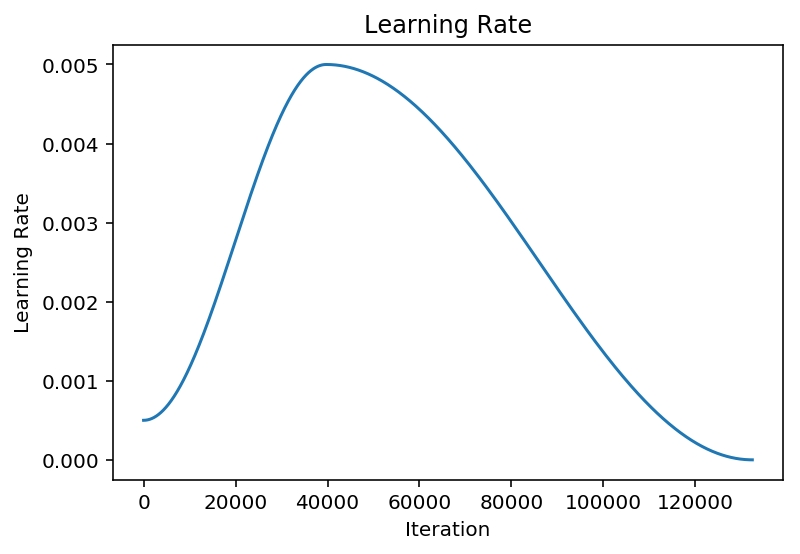

In [188]:
learn.recorder.plot_lr()

In [175]:
torch.save(learn.model.state_dict(), wiki103_path/'pretrained.pth')
pickle.dump(wiki103_vocab, open(wiki103_path/'wiki103_vocab.pkl', 'wb'))

## 4. ULMFiT
Whew! It took a while but we finally got our AWD-LSTM language model pre-trained on WikiText 103. Now we finally get to turn onto the home stretch and build on top of our pre-trained language model a very high-performing movie review classifier.

To accomplish this, I plan to follow the methods outlined in the Universal Language Model Fine-tuning (ULMFiT) for Text Classification [paper](https://arxiv.org/abs/1801.06146) released by Howard and Ruder in 2018. 

With language model pre-training complete, the next step is to fine-tune my language model using the texts contained in the IMDB reviews corpus. Our model already understands general English pretty well. Now we need to get it to be intimately familiar with the kind of language that tends to appear in movie reviews!

#### Fine-tuning the language model on the IMDB movie reviews corpus

In [33]:
# Load the weights and vocab from pre-trained WikiText 103 LM
wiki103_wts   = torch.load(wiki103_path/'pretrained.pth')
wiki103_vocab = pickle.load(open(wiki103_path/'wiki103_vocab.pkl', 'rb'))

There's a few curveballs we'll first have to handle. And the first is that one crucial step for making sure that our pre-trained WikiText 103 language model is absolutely compatible with our IMDB movie reviews corpus is that the numericalized vocab list of each corpus must be *exactly* the same length! This is because our pre-trained RNN inputs layer weight matrix (which comes directly after the word embedding matrix) expects its inputs to be exactly as long as the quantity of words in the vocab that was used to pre-train the model.

In [34]:
len(wiki103_vocab)

60001

My initial implementation of the `NumericalizeProcessor` class [didn't ensure](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/12_text_my_reimplementation.ipynb#NumericalizeProcessor-class---one-other-wrinkle) that the numericalized vocabulary produced by the class was strictly capped at the limit passed to the `max_vocab` argument. The consequence of this was that the WikiText 103 vocab I used to pre-train my language model had a length of `60,001`, while numericalizing the IMDB reviews dataset produced a vocab of length `60,002`.

To prevent this from happening again, and to ensure that I can use the pre-trained model (that expects a vocab of only 60,001 words), I've added logic to the `NumericalizeProcessor` class that ensures a numericalized vocab list is absolutely no longer than the desired cap.

In [35]:
# Prepare the IMDB movie reviews data for language model fine-tuning
bs, bptt = 128, 70

imdb_tokenizer, imdb_numericalizer = TokenizeProcessor(max_workers=8), NumericalizeProcessor(max_vocab=60001)
imdb_lm_data = (TextList.from_files(path, include=['train', 'test', 'unsup'])
                .to_split(partial(random_splitter, p_valid=0.1))
                .to_label(func = lambda y: 0, x_processor = [imdb_tokenizer, imdb_numericalizer])
                .to_lm_databunch(bs, bptt))

In [36]:
imdb_vocab = imdb_numericalizer.vocab
len(imdb_vocab)

60001

Great! The length of the IMDB movie reviews vocab is precisely the length that our pre-trained model expects.

The second curveball is that the numericalized token IDs generated when were preprocessing for our WikiText 103 model will almost certainly be associated with different tokens than the numericalized token IDs of our IMDB reviews dataset. 

Let's demonstrate this, comparing the WikiText 103 numericalization of the word "house" with its IMDB counterpart:

In [37]:
# Compare WikiText 103 numericalization of the word 'house'
wiki103_vocab.index('house')

231

In [38]:
# With that of IMDB movie reviews corpus' numericalization
imdb_vocab = imdb_numericalizer.vocab
imdb_vocab.index('house')

351

Sure enough, in our WikiText 103 vocab, the word 'house' appears at index `231`, while in our IMDB reviews vocab, 'house' appears at index `351`. Why the discrepancy? Our numericalizer sorts token IDs by the respective frequencies with which they appear in their text corpuses. 

Given that the word 'house' appears earlier in the vocab list, we can see that it appears more frequently in WikiText 103 than it does in the IMDB reviews corpus.

Thankfully, there is a straightforward way to make the WikiText 103 pre-trained language model weights compatible with the new IMDB reviews vocabulary. All we need to do is take the rows in the pre-trained model's embedding matrix and re-order them so that their new order matches the indices of words in the IMBD reviews vocabulary.

For example, the embedding for the word 'house' is currently sitting at index `231` inside the embedding matrix. We'll need to relocate the weight values currently in this row to index `351` of the re-ordered embedding matrix. The same must be done for every other word that is in both the WikiText103 vocab and the IMDB reviews vocab. Also, any rows whose words aren't in the IMDB reviews vocab will be removed from the WikiText 103 word embedding matrix.

However, we've now arrived at the third curveball: there will likely be some words in the IMDB reviews vocab that *aren't* in the pre-trained WikiText 103 embedding matrix. The workaround here is to take the remaining empty rows inside the re-ordered embedding matrix that sit at these words' indices, and fill these rows with the *average* weight and bias values of the entire WikiText 103 embedding matrix.

Note that our language model's encoder uses word embedding weights, while the decoder uses both weights and biases.

The method below accomplishes all of the above steps. Also, it'd be handy to know the proper names of the encoder and decoder layers whose weights and or bias we'll need to update:

In [39]:
[layer_name for i, layer_name in enumerate(wiki103_wts)]

['0.emb.weight',
 '0.emb_dropout.emb_layer.weight',
 '0.lstms.0.weight_hh_l0_raw',
 '0.lstms.0.module.weight_ih_l0',
 '0.lstms.0.module.weight_hh_l0',
 '0.lstms.0.module.bias_ih_l0',
 '0.lstms.0.module.bias_hh_l0',
 '0.lstms.1.weight_hh_l0_raw',
 '0.lstms.1.module.weight_ih_l0',
 '0.lstms.1.module.weight_hh_l0',
 '0.lstms.1.module.bias_ih_l0',
 '0.lstms.1.module.bias_hh_l0',
 '1.decoder.weight',
 '1.decoder.bias']

Great, the IMDB numericalized vocab contains only `60,001` words! It should be compatible with our pre-trained language model.

The second curveball is that the numericalized token IDs generated when were preprocessing for our WikiText 103 model will almost certainly be associated with different tokens than the numericalized token IDs of our IMDB reviews dataset. 

Let's demonstrate this, comparing the WikiText 103 numericalization of the word "house" with its IMDB counterpart:

In [40]:
def match_embeds(pre_trained_w, old_vocab, new_vocab):
    w_old = pre_trained_w['0.emb.weight']
    b_old = pre_trained_w['1.decoder.bias']
    w_old_mean, b_old_mean = w_old.mean(dim=0), b_old.mean()
    w_new = w_old.new_zeros(len(new_vocab), w_old.size(1))
    b_new = b_old.new_zeros(len(new_vocab))
    otoi = {v:k for k, v in enumerate(old_vocab)}
    for i, word in enumerate(new_vocab):
        if word in otoi:
            idx = otoi[word]
            w_new[i], b_new[i] = w_old[idx], b_old[idx]
        else:
            w_new[i], b_new[i] = w_old_mean, b_old_mean
    pre_trained_w['0.emb.weight']                   = w_new
    pre_trained_w['0.emb_dropout.emb_layer.weight'] = w_new
    pre_trained_w['1.decoder.weight']               = w_new
    pre_trained_w['1.decoder.bias']                 = b_new
    return pre_trained_w

In [41]:
# Set aside the old, wiki103 weights and biases the word 'house', 
# so that we can verify the above method works properly.
wiki103_house_emb_wts = wiki103_wts['0.emb.weight']
wiki103_house_emb_dp_wts = wiki103_wts['0.emb_dropout.emb_layer.weight']
wiki103_house_dec_wts = wiki103_wts['1.decoder.weight']
wiki103_house_dec_bias = wiki103_wts['1.decoder.bias']

# Indices of word 'house' in each vocab
wiki103_house_idx = wiki103_vocab.index('house')
imdb_house_idx = imdb_vocab.index('house')

In [42]:
# Now, sync the weight embedding matrix to the order of 
# IMDB reviews vocab words.
re_ordered_weights = match_embeds(wiki103_wts, wiki103_vocab, imdb_vocab)

For both the encoder and decoder, let's make sure that the embedding weights and bias for the word 'house' have been moved to the index that is the same as the word's index in the IMDB reviews vocab.

Verify that encoder embedding weights for 'house' were properly relocated:

In [43]:
test_near(re_ordered_weights['0.emb.weight'][imdb_house_idx],
          wiki103_house_emb_wts[wiki103_house_idx])

Verify that encoder embedding dropped-out weights for 'house' were properly relocated:

In [44]:
test_near(re_ordered_weights['0.emb_dropout.emb_layer.weight'][imdb_house_idx],
          wiki103_house_emb_dp_wts[wiki103_house_idx])

Verify that decoder embedding weights for 'house' were properly relocated:

In [45]:
test_near(re_ordered_weights['1.decoder.weight'][imdb_house_idx],
          wiki103_house_dec_wts[wiki103_house_idx])

Verify that decoder embedding bias for 'house' was properly relocated:

In [46]:
test_near(re_ordered_weights['1.decoder.bias'][imdb_house_idx],
          wiki103_house_dec_bias[wiki103_house_idx])

Great! Everything looks to be in the proper position. We're now ready to load the pre-trained weights containing the now re-ordered embedding weights back into our language model:

In [36]:
dropouts = np.array([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.5
pad_tok_idx = imdb_vocab.index(PAD)
embed_size, nh, n_layers = 300, 300, 2
model = get_language_model(len(imdb_vocab), embed_size, nh, n_layers, pad_tok_idx, *dropouts)

In [48]:
model.load_state_dict(re_ordered_weights);

It'll be a great idea to use discriminative learning rates so we can train different layer groups of our model at different learning rate schedules. This is the [exact same concept](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11a_transfer_learning_my_reimplementation.ipynb?flush_cache=true#Transfer-Learning-Technique-4:-Discriminative-learning-rates-for-different-parameter-groups) that we implemented for computer vision transfer learning a few notebooks ago. Let's take a look at our model's layers, in order to get an idea of how we should break it apart into separate layer groups:

In [49]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (emb): Embedding(60001, 300, padding_idx=1)
    (emb_dropout): EmbeddingDropout(
      (emb_layer): Embedding(60001, 300, padding_idx=1)
    )
    (lstms): ModuleList(
      (0): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(300, 300, batch_first=True)
      )
    )
    (rnn_input_dropout): RNNDropout()
    (rnn_hidden_dropouts): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (output_dropout): RNNDropout()
    (decoder): Linear(in_features=300, out_features=60001, bias=True)
  )
)

#### Language model layer group splitter
What we'll do is create separate layer groups for each of the two LSTM layers inside the RNN encoder. These two groups will also include their LSTM layer's associated dropout layer (the dropout that is applied to the outputs of an LSTM layer; known as `rnn_hidden_dropouts` above). A third and final layer group will contain the word embedding layer (and its dropouts), the dropout layer `rnn_input_dropout`, which is applied to the inputs the RNN encoder (which are the outputs of the embedding dropout layer) and the linear decoder.

Here's a splitter that we can pass to our learner object during training. It'll separate our model's layers into the above three groups:

In [32]:
#export

def lm_splitter(model):
    layer_groups = []
    for i in range(len(model[0].lstms)):
        layer_groups.append(nn.Sequential(model[0].lstms[i], model[0].rnn_hidden_dropouts[i]))
    layer_groups += [nn.Sequential(model[0].emb, model[0].emb_dropout, model[0].rnn_input_dropout, model[1])]
    return [list(o.parameters()) for o in layer_groups]

The third and final layer group that contains the embedding layers and linear decoder will need the most training. There may be some new words in our embedding vectors that weren't part of the vocab used to pre-train the model, therefore our model will need extra time to learn more appropriate values for these embeddings (recall that they are initialized as the mean of embedding layer weights or biases).

Thus, we'll start off by freezing the two groups that contain LSTM layers. We can accomplish this by setting the learning rates for both of those groups to zero! This technique was also introduced for computer vision back in the [transfer learning notebook](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11a_transfer_learning_my_reimplementation.ipynb?flush_cache=true#Transfer-Learning-Technique-4:-Discriminative-learning-rates-for-different-parameter-groups).

In [38]:
callback_funcs = [partial(AvgStatsCallback, accuracy_flat),
                  CudaCallback,
                  Recorder,
                  partial(GradientClipping, clip=0.1),
                  partial(RNNTrainer, α=2., β=1.),
                  ProgressBarCallback]

In [51]:
learn = Learner(model, imdb_lm_data, cross_entropy_flat, opt_func=adam_opt(),
                callback_funcs=callback_funcs, splitter=lm_splitter)

lr = 2e-2
callback_scheduler = sched_1cycle([0, 0, lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [52]:
learn.fit(3, callback_funcs=callback_scheduler)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.540476,0.242762,4.344347,0.257924,47:43
1,4.378102,0.251189,4.297046,0.260480,47:38
2,4.273042,0.258025,4.235306,0.265718,47:28


In [53]:
torch.save(learn.model.state_dict(), path/'finetuned_layer_grp3.pth')
pickle.dump(imdb_vocab, open(path/'imdb_vocab.pkl', 'wb'))

Now we train all three layer groups using discriminative learning rates.

In [34]:
finetuned_layer_grp3 = torch.load(path/'finetuned_layer_grp3.pth')
imdb_vocab           = pickle.load(open(path/'imdb_vocab.pkl', 'rb'))

In [39]:
model.load_state_dict(finetuned_layer_grp3);

In [40]:
learn = Learner(model, imdb_lm_data, cross_entropy_flat, opt_func=adam_opt(),
                callback_funcs=callback_funcs, splitter=lm_splitter)

lr = 2e-3
callback_scheduler = sched_1cycle([lr/2., lr/2., lr], pct_start=0.5, mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [41]:
learn.fit(10, callback_funcs=callback_scheduler)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.195715,0.265180,4.120334,0.274828,48:05
1,4.148474,0.270486,4.093003,0.277989,47:27
2,4.109431,0.274691,4.070571,0.281148,47:43
3,4.074794,0.278449,4.054187,0.283202,48:05
4,4.045515,0.281438,4.039062,0.285201,47:25
5,4.021289,0.283796,4.026320,0.286679,47:47
6,3.998403,0.285964,4.016414,0.288067,48:09
7,3.978632,0.287842,4.007289,0.288949,47:31
8,3.963338,0.289297,4.001481,0.289749,47:40
9,3.954806,0.290095,4.000451,0.289829,47:55


In [42]:
pickle.dump(imdb_vocab, open(path/'imdb_vocab.pkl', 'wb'))
torch.save(learn.model[0].state_dict(), path/'finetuned_all_layers_enc.pth')
torch.save(learn.model.state_dict(), path/'finetuned_all_layers.pth')

#### Training the IMDB Movie Review Classifier
We're now on the home stretch! It's time to build a movie review classifier on top of our now fine-tuned language model! 

In [35]:
imdb_vocab = pickle.load(open(path/'imdb_vocab.pkl', 'rb'))

The first step is to create a databunch of our IMDB reviews data, with dataloaders that are able to return padded and somewhat randomly sorted (in an overall order of longest to shortest) complete text documents. Isn't it amazing that we can invoke all the classifier pre-processing logic that [we defined earlier](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/12_text_my_reimplementation.ipynb#Batching-for-Text-Classification), in just four lines of code!

Note that unlike when creating a databunch for language model training, we don't have to worry about passing the `bptt` parameter when creating a databunch for document classification. Our model will nonetheless still need to know our `bptt` value, so we'll specify this later on down when we initialize our classifier model.

In [36]:
# Prepare the IMDB movie reviews data for document classification
bs = 64

imdb_tokenizer = TokenizeProcessor(max_workers=8)
imdb_numericalizer = NumericalizeProcessor(vocab=imdb_vocab)
imdb_category_processor = CategoryProcessor()

imdb_clas_data = (TextList.from_files(path, include=['train', 'test'])
                  .to_split(partial(grandparent_splitter, valid_name='test'))
                  .to_label(func = parent_labeler, 
                            x_processor = [imdb_tokenizer, imdb_numericalizer],
                            y_processor = imdb_category_processor)
                  .to_text_clas_databunch(bs))

#### Ignoring Padding in the AWD-LSTM encoder
[As discussed previously](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/12_text_my_reimplementation.ipynb#Text-Document-Padding), when training a model to classify text documents, mini-batch training is only possible if we pad all but the longest document of a batch so that all documents have an identical length. In order to load batches of text documents onto the GPU, our dataloaders need to be able to perform this padding.

However, when training (and later when performing inference), we absolutely must prevent our model from treating padding characters is if they were part of the original documents. We need to have a way to tell our model to ignore padding characters and it turns out that there are two utility functions from PyTorch that we can use to accomplish this:

In [37]:
#export

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

Let's walk through a toy example that illustrates how we can use both of these PyTorch utilities to help our model *ignore* padding tokens.

If we were to begin training right now, here are the lengths of all batches that our dataloader would feed into our model at the beginning of the first iteration:

In [35]:
x, y = next(iter(imdb_clas_data.train_dl))
x.size()

torch.Size([64, 3352])

Here are the document lengths for each the first five of these batches, not including padding tokens:

In [36]:
doc_lengths = x.size(1) - (x == 1).sum(1)
doc_lengths[:5]

tensor([3352, 1788, 1705, 1519, 1487])

Our mini-batched training inputs first go through a word embedding layer before proceeding through the rest of our model's layers. Embedding layers have a vector that corresponds to the padding token, so its okay to pass our inputs, padding and all, into the word embedding layer:

In [37]:
test_embed_layer = nn.Embedding(len(imdb_vocab), 300)
test_embed_layer(x).shape

torch.Size([64, 3352, 300])

However, the point at which our model inputs have exited the embedding layer, and before they enter the RNN module, is when must do something to make our model ignore the padding tokens. If we don't do this right then, our model's subsequent LSTM layers will learn to take the amount of padding tokens present in a text document into account when differentiating between "positive" and "negative" movie reviews.

Therefore, we'll apply the first utility function, [`pack_padded_sequence()`](https://pytorch.org/docs/stable/nn.html?highlight=pack_padded_sequence&source=post_page---------------------------#torch.nn.utils.rnn.pack_padded_sequence) to the outputs of the word embedding layer. Doing this takes these outputs, which at this point still contain padding, and places them inside a [`PackedSequence()` object](https://pytorch.org/docs/stable/nn.html?highlight=pack_padded_sequence&source=post_page---------------------------#torch.nn.utils.rnn.PackedSequence). 

Here's what a `PackedSequence()` object accomplishes:
1. Temporarily setting aside all padding tokens contained in each mini-batch, so that when the batches are passed through our model's LSTM layers, no calculations, backprop, etc. are performed using any of these padding tokens.

2. While at the same time, preserving the tensor's shape so that it can be passed through the LSTM layers without losing any of the speed that CuDNN makes possible.

In [38]:
packed = pack_padded_sequence(test_embed_layer(x), doc_lengths, batch_first=True)
packed

PackedSequence(data=tensor([[ 0.5144, -0.1888,  1.4997,  ...,  2.2729,  1.1122,  1.2661],
        [ 0.5144, -0.1888,  1.4997,  ...,  2.2729,  1.1122,  1.2661],
        [ 0.5144, -0.1888,  1.4997,  ...,  2.2729,  1.1122,  1.2661],
        ...,
        [-0.8081, -0.0260, -0.2637,  ...,  0.4619,  0.1137,  0.7406],
        [ 0.5119,  1.5964,  0.1244,  ...,  2.7820,  1.2427,  0.0356],
        [ 0.4875, -0.3466,  0.0914,  ..., -1.2454, -1.4905,  1.0074]],
       grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([64, 64, 64,  ...,  1,  1,  1]), sorted_indices=None, unsorted_indices=None)

In [39]:
packed.data.shape

torch.Size([78345, 300])

In [40]:
len(packed.batch_sizes)

3352

Now what's going on with the tensor that's stored in the `PackedSequence()` object's `batch_sizes` attribute? The length of this tensor is `3,352`, which is the length of the longest text document in the batch, and therefore also the length of all (padded) mini-batches our dataloader will feed into the model at the first training iteration. Notice that the first several entries in `batch_sizes` are `64`, which is what we've chosen as our dataloader's batch size. However, as we go further on down, these numbers begin to descrease, eventually dropping to `1`.

All that these numbers indicate is: at a given token position inside a text document, the amount of minibatches that have an actual, non-padding token residing at that index. The first several entries are 64 because all 64 mini-batches contain text documents that are long enough such that they all have non-padding tokens at these relatively early positions. However, as we go on, at token positions of around 1,000, we begin to see that a few batches' documents have already concluded and that at this and all subsequent indices, these documents only contain padding tokens. The pattern continues, at by the time we've reached token indices near the end of the longest document, close to 3,352, there remains only one batch that has non-padding tokens. This is the batch that contains our longest text document.

In [41]:
packed.batch_sizes[:5], packed.batch_sizes[995:1000], packed.batch_sizes[-2000:]

(tensor([64, 64, 64, 64, 64]),
 tensor([64, 64, 64, 64, 64]),
 tensor([8, 8, 8,  ..., 1, 1, 1]))

Let's simulate what it's like to take this `PackedSequence()` object and pass it through an RNN's LSTM layer:

In [42]:
test_lstm_layer = nn.LSTM(300, 300, 2)
y, h = test_lstm_layer(packed)

In [43]:
y.data.shape, h[0].shape

(torch.Size([78345, 300]), torch.Size([2, 64, 300]))

Once the `PackedSequence()` object has passed through all the LSTM layers, and all padding tokens have been dutifully ignored, it is time add these tokens back to the text contained in each mini-batch, so that the LSTM layers' outputs can be passed through any fully connected layers and onto our model's classification head.

Now you might be thinking, *"if it's dangerous to pass padding tokens through LSTM layers, wouldn't it also be possibly dangerous to pass padding tokens through the final layers of our model?"* 

The answer to that question is a definite *yes*! We will absolutely need to keep the padding tokens from influencing how we compute our loss value. However, `PackedSequence()` objects *can't* be passed through fully connected layers. So we will need to use another trick called *concat pooling*, which we will introduce shortly.

But first, we need to convert the `PackedSequence()` object that will have just emerged from our model's LSTM layers, in order to be able to pass these LSTM layer outputs through the rest of our model. We'll use the second PyTorch utility, [`pad_packed_sequence()`](https://pytorch.org/docs/stable/nn.html?highlight=pack_padded_sequence&source=post_page---------------------------#torch.nn.utils.rnn.pad_packed_sequence), to take the padding tokens that had been set aside before the mini-batches were run through the LSTM layers, and return them to their original positions.

Returning to our toy example, here is what it would look like to add the padding tokens back to LSTM layer outputs:

In [44]:
unpacked = pad_packed_sequence(y, batch_first=True)
unpacked

(tensor([[[ 0.0073, -0.0110,  0.0015,  ...,  0.0038,  0.0066, -0.0115],
          [-0.0030, -0.0130,  0.0127,  ..., -0.0015, -0.0010,  0.0133],
          [-0.0146, -0.0256,  0.0111,  ..., -0.0079,  0.0234, -0.0005],
          ...,
          [ 0.0515,  0.0549, -0.0253,  ..., -0.0041,  0.0478, -0.0274],
          [ 0.0440,  0.0281, -0.0312,  ...,  0.0045,  0.0390, -0.0149],
          [ 0.0287,  0.0002, -0.0441,  ..., -0.0137,  0.0560, -0.0272]],
 
         [[ 0.0073, -0.0110,  0.0015,  ...,  0.0038,  0.0066, -0.0115],
          [ 0.0050, -0.0300,  0.0116,  ..., -0.0157,  0.0035, -0.0186],
          [ 0.0041, -0.0274,  0.0194,  ..., -0.0370,  0.0062, -0.0213],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0073, -0.0110,  0.0015,  ...,  0.0038,  0.0066, -0.0115],
          [-0.0030, -0.0130,

`pad_packed_sequence()` returns a tuple. The first element contains parameter weights for each token in each of the 64 mini-batches. Weights are also included for padding tokens, but notice that these weights are all `0.0000`. The tuple's second element is a list of the original, non-padded, document lengths of each of the 64 mini-batches.

In [45]:
unpacked[0].shape, unpacked[1].shape

(torch.Size([64, 3352, 300]), torch.Size([64]))

So far so good, but in order to actually use both of these utility functions with our model, we need to update our `AWD_LSTM` class to apply `pack_padded_sequence()` before the text inputs enter the LSTM layers, and then apply `pad_packed_sequence()` to the outputs of the LSTM layers:

In [38]:
#export

class AWD_LSTM_pad(nn.Module):
    """
    Based on approaches recommended by Smerity et. al. 
    in https://arxiv.org/abs/1708.02182
    """
    
    initrange = 0.1
    
    def __init__(self, vocab_size, emb_size, n_hid, n_layers, pad_token,
                 embed_p=0.1, hidden_p=0.2, input_p=0.6, weight_p=0.5):
        super().__init__()
        self.bs, self.emb_size, self.n_hid, self.n_layers = 1, emb_size, n_hid, n_layers
        self.pad_token = pad_token
        
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_token)
        self.emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.emb_dropout = EmbeddingDropout(self.emb, embed_p)
        
        self.lstms = [nn.LSTM(emb_size if layer == 0 else n_hid, 
                             (n_hid if layer != n_layers - 1 else emb_size), 1,
                             batch_first = True) for layer in range(n_layers)]
        # Use WeightDropout for LSTM gates' hidden layers.
        self.lstms = nn.ModuleList([WeightDropout(lstm, weight_p) for lstm in self.lstms])
        # Use RNNDropout on inputs to & outputs of each LSTM layer.
        # LSTM layer outputs can be thought of as the "hidden layer 
        # outputs" of the overall RNN network.
        self.rnn_input_dropout = RNNDropout(input_p)
        self.rnn_hidden_dropouts = nn.ModuleList([RNNDropout(hidden_p) for layer in range(n_layers)])
        
    def _new_empty_layer(self, layer):
        """
        Get one brand new, empty version of a given layer.
        Returns a tuple of two tensors, each sized to store 
        the same number of weight parameters originally held 
        in the layer. One empty tensor is for the weights; 
        the other is for their gradients.
        """ 
        nh = self.n_hid if layer != self.n_layers - 1 else self.emb_size
        empty_param_tensor = next(self.parameters()).new(1, self.bs, nh).zero_()
        return (empty_param_tensor, empty_param_tensor)
        
    def reset(self):
        """
        Reset the states of all hidden layers.
        """
        self.hidden = [self._new_empty_layer(layer) for layer in range(self.n_layers)]
        
    def forward(self, input):
        bs, padded_doc_length = input.size()
        
        # Make a mask that indicates location of weights of each 
        # padding token in all batches.
        pad_mask = (input == self.pad_token)
        unpadded_doc_lengths = padded_doc_length - pad_mask.long().sum(dim=1)
        
        # Remove any empty (only have padding tokens) batches:
        n_empty_batches = (unpadded_doc_lengths == 0).sum()
        if n_empty_batches > 0:               # If any batches are empty, those batches
            input = input[:-n_empty_batches]  # will come at the end of the inputs.
            unpadded_doc_lengths = unpadded_doc_lengths[:-n_empty_batches]                           
            self.hidden = [(h[0][:,:input.size(0)], h[1][:,:input.size(0)]) for h in self.hidden]
        
        raw_output = self.rnn_input_dropout(self.emb_dropout(input))
        new_hidden, raw_outputs, outputs = [], [], []
        for i, (lstm_layer, rnn_hidden_dropout) in enumerate(zip(self.lstms, self.rnn_hidden_dropouts)):
            # Pack embedding layer outputs so that padding will be
            # ignored when they're fed into the LSTM layers:
            raw_output = pack_padded_sequence(raw_output, unpadded_doc_lengths, batch_first=True)
            # Run through LSTM layer
            raw_output, new_h = lstm_layer(raw_output, self.hidden[i])
            # Unpack LSTM layer outputs, adding padding tokens back to 
            # weights (padding tokens' weights will all be 0.0000)
            raw_output = pad_packed_sequence(raw_output, batch_first=True)[0]
            
            # Store LSTM layer's hidden state:
            new_hidden.append(new_h)
            # Store LSTM layer's non-dropped-out output:
            raw_outputs.append(raw_output)
            # Run LSTM layer's output through dropout
            if i != self.n_layers - 1: 
                raw_output = rnn_hidden_dropout(raw_output)
            # And store LSTM layer's output after dropout
            # has been applied to it:
            outputs.append(raw_output)
        # Goal with following line is two-fold:
        # 1. Detach layers' hidden states after forward pass, 
        #    so that we remove them from computation graph 
        #    and don't perform backprop on them.
        # 2. But also save them so that we can use them as inputs
        #    to our LSTM layers on the next forward pass.
        self.hidden = to_detach(new_hidden)
        # raw_outputs = with no dropout; outputs = with dropout
        return raw_outputs, outputs, pad_mask

#### Building the Classifier Head using Concat Pooling
So now we're able to run our mini-batches through LSTM layers while keeping their padding tokens from interfering with the LSTMs' ability to learn the difference between positive and negative movie reviews.

However, in order to pass the outputs of our model's LSTM layers onto its classifier head, we had to add empty weights for each padding token back onto the end of each batch's parameter weights. Concretely, this means that right after the LSTM layers, the weight matrix containing the parameter weights for all input document tokens across all 64 batches now contains 300 values of `0.0000` for each padding token in each batch.

And as it currently stands, all these `0.0000` values are going to be passed through one or more fully connected layers and activations inside the model's classifier head. And if we don't do something to prevent it from happening, the padding token weights' presence will surely make it difficult for the classifier module to convert our LSTM output into accurate classifications.

The long and short of it is that we're going to need a way to get our model's classifier head to ignore the weight parameters that belong to padding tokens. And we're not going to be able to rely on the `PackedSequence()` class that we used to pass embedding layer outputs through our model's LSTM layers because it's not compatible with fully connected, linear layers (it's only [designed to work with RNN layers](https://pytorch.org/docs/stable/_modules/torch/nn/utils/rnn.html)).

Thankfully, there are tricks we can use to ignore padding inside our model's classifier head. In fact, there is one trick for each of the three elements that are used by a ULMFiT classifier head:
1. The (dropped-out) output of the encoder's final LSTM layer for the final timestep.
2. The max pool of the (dropped-out) output of the encoder's final LSTM layer, over as many timesteps as will fit inside GPU memory (ideally, all timesteps/every token in the document).
3. The average pool of the (dropped-out) output of the encoder's final LSTM layer, over as many timesteps as will fit inside GPU memory (ideally, all timesteps/every token in the document).

Before we get to the tricks for ignoring padding, let's take a brief detour and try to understand why our classifier makes use of each of the above three elements: 

Note that most document classification models prior to ULMFiT had relied solely on `1.`, the final LSTM layer's outputs at the final timestep, for generating predictions. However, [as mentioned](https://arxiv.org/abs/1801.06146) by Jeremy and Sebastian in their paper, the clues that are most helpful for classifying a real-world document can be found anywhere inside the document. When input documents consist of hundreds of words or more, this information may well be inadvertently ignored if we only look at the words whose weights are contained in the portion of the final LSTM layer's output that belongs to the final timestep (in other words, belongs to the final non-padding token from each document). This is the motivation that spurred Jeremy and Sylvain to *concatenate* final timestep information with both a max pooling and an average pooling of final LSTM layer outputs that cover as many timesteps as possible (ideally all non-padding timesteps/tokens in each document). The idea is, obviously, to allow our classifier to consider information from as broad a portion of a document as possible, before deciding on the most appropriate classification.

We'll shortly write a class called `PoolingLinearClassifier` that calculates this average and max pooling, concatenates it to the final LSTM layer's final timestep output, and then runs this entire tensor through a succession of several clusters of batchnorm/dropout/linear/ReLU layers. The output of these final layers is then passed through a softmax and loss will be calculated (or predictions will be returned, if the model is performing inference).

First, however, we'll illustrate, mechanically-speaking, how concat pooling in the classifier head actually works. Just below is a class, `ConcatPooling`, that we'll use to concretely demonstrate just how we capture all three of the elements that we concatenate together at the beginning of the classifier head (so that we can pass them through its fully connected layers). 

In each case, you'll also be able to see how padding tokens are ignored. Designing the AWD_LSTM module to also return a mask that contains the locations of each padding token's weights will turn out to have been the most crucial trick.

In [39]:
class ConcatPooling(nn.Module):
    def forward(self, input):
        # 'input' will be the output of an encoder's AWD_LSTM module:
        # 'raw_outputs' = outputs of encoder's LSTM layers, with no dropout
        # 'outputs' = outputs of encoder's LSTM layers, with dropout
        # 'pad_mask' = A mask that indicates location of weights of each 
        #              padding token in all batches
        raw_outputs, outputs, pad_mask = input
        
        # Final LSTM layer output across all timesteps.
        # Shape is: batch_size x longest_doc_length x lstm_hidden_layer_size
        output = outputs[-1]
        
        # The lengths of all documents, not counting padding.
        lengths = output.size(1) - pad_mask.long().sum(dim=1)
        
        # Max pooling of weights final LSTM layer outputs 
        # for *all* timesteps, ignoring padding.
        max_pool = output.masked_fill(pad_mask[:,:,None], -float('inf')).max(dim=1)[0]
        
        # Average pooling of weights final LSTM layer outputs 
        # for *all* timesteps, ignoring padding.
        avg_pool = output.masked_fill(pad_mask[:,:,None], 0).sum(dim=1)
        avg_pool.div_(lengths.type(avg_pool.dtype)[:,None])
        
        # Get the final timestep from the final LSTM layer's output 
        # and ignore
        # Then concatenate this to the max and avg pooling of 
        # all timesteps' outputs.
        x = torch.cat([output[torch.arange(0, output.size(0)), lengths - 1], max_pool, avg_pool], 1)
        
        # Return concatenated tensor, x.
        return x

The above `ConcatPooling` class contains a complete, working implementation of concat pooling.

Going back once more to a toy example, let's simulate what it's like to pass a batch of text documents through our RNN encoder, and then concat pool its outputs using this class:

In [40]:
x, y = next(iter(imdb_clas_data.train_dl))

In [41]:
embed_size, nh, n_layers = 300, 300, 2
pad_tok_idx = imdb_vocab.index(PAD)

rnn_encoder = AWD_LSTM_pad(len(imdb_vocab), embed_size, n_hid=nh,
                           n_layers=n_layers, pad_token=pad_tok_idx)
concat_pool = ConcatPooling()
rnn_encoder.bs = bs # Make sure encoder knows it should have 
                    # a batch size of 64.
rnn_encoder.reset()

In [42]:
raw_outputs, outputs, pad_mask = rnn_encoder(x)
c = concat_pool((raw_outputs, outputs, pad_mask))

Here's what the model input tensors look like when coming right out of the dataloader. Notice that all batches other than the first batch, which contains the longest document, have 1s at their end. These 1s are padding tokens:

In [43]:
x

tensor([[    2,     7,  1150,  ..., 15946,    24,     3],
        [    2,     7,    19,  ...,     1,     1,     1],
        [    2,     7,   170,  ...,     1,     1,     1],
        ...,
        [    2,    18,   320,  ...,     1,     1,     1],
        [    2,     7,  9546,  ...,     1,     1,     1],
        [    2,     7,    48,  ...,     1,     1,     1]])

In [44]:
x.shape

torch.Size([64, 3352])

And here's the result of concat pooling the RNN encoder's final LSTM layer output:

In [45]:
c

tensor([[ 0.0081,  0.0115,  0.0465,  ..., -0.0312,  0.0423,  0.0080],
        [ 0.0085,  0.0126,  0.0402,  ..., -0.0313,  0.0416,  0.0078],
        [ 0.0096,  0.0118,  0.0397,  ..., -0.0316,  0.0420,  0.0081],
        ...,
        [ 0.0115,  0.0146,  0.0382,  ..., -0.0314,  0.0413,  0.0081],
        [ 0.0128,  0.0095,  0.0415,  ..., -0.0313,  0.0416,  0.0083],
        [ 0.0085,  0.0143,  0.0453,  ..., -0.0312,  0.0415,  0.0073]],
       grad_fn=<CatBackward>)

In [46]:
c.shape

torch.Size([64, 900])

Now, let's go over the logic in the `ConcatPooling` class with a fine-tooth comb, so that we can see exactly how concat pooling works. 

Let's start by looking at the input used to generate each of the three components (that eventually get concatenated together). As acknowledged above, this input is merely the output of the AWD-LSTM encoder's final LSTM layer:

In [48]:
output = outputs[-1]
output

tensor([[[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 1.0733e-02, -4.8371e-03,  3.4682e-02,  ..., -3.8023e-02,
           3.4135e-02,  9.0957e-03],
         ...,
         [ 5.8439e-03,  6.9097e-03,  3.4462e-02,  ..., -3.2931e-02,
           3.3926e-02,  9.4933e-03],
         [ 5.7984e-03,  8.8254e-03,  4.5234e-02,  ..., -3.1953e-02,
           3.8019e-02,  1.1301e-02],
         [ 8.1083e-03,  1.1540e-02,  4.6496e-02,  ..., -3.3262e-02,
           3.5563e-02,  4.8950e-03]],

        [[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 9.9272e-03, -7.8408e-05,  3.3186e-02,  ..., -3.7564e-02,
           3.8054e-02,  8.1933e-03],
         ...,
         [ 0.0000e+00,  0

In [49]:
output.shape

torch.Size([64, 3352, 300])

The output of the AWD-LSTM encoder's final LSTM layer contains 300 (the size of the LSTM layer) parameter weights for each of the 3,352 tokens, padding or not, in each of the 64 batches. All of the `0.0000` values are weights of padding tokens, and there is a set of 300 of these `0.0000` values that corresponds to each one padding token that's in the network's input tensor, `x`, that we printed out above.

It is from the above `output` tensor that we build each of the three tensors that get pooled and or concatenated together:
1. The (dropped-out) output of the encoder's final LSTM layer for the final timestep.
2. The max pool of the (dropped-out) output of the encoder's final LSTM layer, over as many timesteps as will fit inside GPU memory.
3. The average pool of the (dropped-out) output of the encoder's final LSTM layer, over as many timesteps as will fit inside GPU memory.

Let's walk through precisely how we build each of the above three components. In each case we'll detail how padding tokens get ignored. Here's how we get `1.`, the final timestep's portion of the final LSTM layer's output:

Step 1: Get the lengths of all documents in the mini-batch, not counting padding:

In [50]:
# The lengths of all documents, not counting padding.
lengths = output.size(1) - pad_mask.long().sum(dim=1)
lengths

tensor([3352, 1742, 1482, 1446, 1423, 1355, 1353, 1350, 1349, 1333, 1306, 1305,
        1282, 1271, 1265, 1231, 1230, 1220, 1218, 1218, 1213, 1213, 1213, 1205,
        1203, 1202, 1193, 1192, 1190, 1186, 1183, 1182, 1179, 1178, 1174, 1171,
        1169, 1169, 1168, 1164, 1161, 1159, 1157, 1157, 1150, 1147, 1147, 1131,
        1130, 1126, 1122, 1113, 1098, 1094, 1093, 1089, 1088, 1087, 1085, 1080,
        1071, 1067, 1066, 1063])

In [51]:
lengths.shape

torch.Size([64])

Step 2: Get the index of the final word that's not padding in each document:

In [52]:
# Indices of the final non-padding word in each document.
lengths - 1

tensor([3351, 1741, 1481, 1445, 1422, 1354, 1352, 1349, 1348, 1332, 1305, 1304,
        1281, 1270, 1264, 1230, 1229, 1219, 1217, 1217, 1212, 1212, 1212, 1204,
        1202, 1201, 1192, 1191, 1189, 1185, 1182, 1181, 1178, 1177, 1173, 1170,
        1168, 1168, 1167, 1163, 1160, 1158, 1156, 1156, 1149, 1146, 1146, 1130,
        1129, 1125, 1121, 1112, 1097, 1093, 1092, 1088, 1087, 1086, 1084, 1079,
        1070, 1066, 1065, 1062])

Step 3: Get the index of each document in the mini-batch:

In [53]:
# Indices of all 64 documents in the mini-batch
torch.arange(0, output.size(0))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

And by putting the above three steps together, we can get the parameter weights as of the timestep that belongs to the final non-padding token in each of the 64 documents in the batch:

In [54]:
concatpool_part1 = output[torch.arange(0, output.size(0)), lengths - 1]
concatpool_part1

tensor([[ 0.0081,  0.0115,  0.0465,  ..., -0.0333,  0.0356,  0.0049],
        [ 0.0085,  0.0126,  0.0402,  ..., -0.0387,  0.0452,  0.0012],
        [ 0.0096,  0.0118,  0.0397,  ..., -0.0372,  0.0420,  0.0103],
        ...,
        [ 0.0115,  0.0146,  0.0382,  ..., -0.0366,  0.0377,  0.0007],
        [ 0.0128,  0.0095,  0.0415,  ..., -0.0415,  0.0371, -0.0026],
        [ 0.0085,  0.0143,  0.0453,  ..., -0.0391,  0.0406,  0.0073]],
       grad_fn=<IndexBackward>)

In [55]:
concatpool_part1.shape

torch.Size([64, 300])

So far, so good. We have the first component of our concat pooling. As we said earlier, most text classifiers stop right here, and don't bother looking at any information outside of what's encapsulated in the parameter weights as of timestep of the final non-padding word in each document. Note that the weights at this timestep are influenced by the tokens that occurred within the previous `bptt` timesteps of this point.

However, we want to look classify documents only after taking the time to look beyond the previous `bptt` timesteps, all the way back to the beginning of each document. This motivation brings us to the second component of concat pooling, which is the max pooling of weights contained in final LSTM layer outputs, for *all* timesteps. When computing this max pooling, we will ignore the weights in all documents that are sitting at timesteps where a padding token appeared in the document.

Step 1: Take the mask that indicates, with a `1`, the location of each token, or timestep, in each document that contains padding, and add an extra dimension that corresponds to the dimension in which each timestep/tokens 300 parameter weights are stored.

In [56]:
pad_mask

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [57]:
pad_mask.shape

torch.Size([64, 3352])

In [58]:
pad_mask[:,:,None]

tensor([[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]]], dtype=torch.uint8)

In [59]:
pad_mask[:,:,None].shape

torch.Size([64, 3352, 1])

In [60]:
output.shape

torch.Size([64, 3352, 300])

Step 2: Use this mask, now containing a "weights" dimension, to replace the `0.0000` values that fill the parameter weights of any padding token residing at any timestep inside any document with negative infinity, `-inf`, values.

In [61]:
output.masked_fill(pad_mask[:,:,None], -float('inf'))

tensor([[[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 1.0733e-02, -4.8371e-03,  3.4682e-02,  ..., -3.8023e-02,
           3.4135e-02,  9.0957e-03],
         ...,
         [ 5.8439e-03,  6.9097e-03,  3.4462e-02,  ..., -3.2931e-02,
           3.3926e-02,  9.4933e-03],
         [ 5.7984e-03,  8.8254e-03,  4.5234e-02,  ..., -3.1953e-02,
           3.8019e-02,  1.1301e-02],
         [ 8.1083e-03,  1.1540e-02,  4.6496e-02,  ..., -3.3262e-02,
           3.5563e-02,  4.8950e-03]],

        [[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 9.9272e-03, -7.8408e-05,  3.3186e-02,  ..., -3.7564e-02,
           3.8054e-02,  8.1933e-03],
         ...,
         [       -inf,   

In [62]:
output.masked_fill(pad_mask[:,:,None], -float('inf')).shape

torch.Size([64, 3352, 300])

Putting the above steps together, we're ready to compute the max pooling of this weight matrix. What we're doing is using the `.max()` function to find the largest weight vector (of 300 weights) out of any timestep, of every document. Depending on the document, this will largest weight vector could be found at different timesteps. 

By setting padding weight values to `-inf`, there's zero chance our `.max()` function would ever any weight vector that belongs to a padding token as the largest out of a document's weight vectors from all its timesteps.

In [63]:
concatpool_part2 = output.masked_fill(pad_mask[:,:,None], -float('inf')).max(dim=1)[0]
concatpool_part2

tensor([[ 0.0271,  0.0292,  0.0612,  ..., -0.0137,  0.0579,  0.0234],
        [ 0.0253,  0.0257,  0.0565,  ..., -0.0165,  0.0575,  0.0244],
        [ 0.0218,  0.0280,  0.0572,  ..., -0.0184,  0.0599,  0.0237],
        ...,
        [ 0.0232,  0.0288,  0.0572,  ..., -0.0163,  0.0569,  0.0253],
        [ 0.0212,  0.0257,  0.0625,  ..., -0.0162,  0.0608,  0.0233],
        [ 0.0219,  0.0283,  0.0574,  ..., -0.0171,  0.0555,  0.0282]],
       grad_fn=<MaxBackward0>)

In [64]:
concatpool_part2.shape

torch.Size([64, 300])

Okay, so we've got two of the three components of concat pooling all implemented. It's time to look at all the information encapsulated in the weights at each non-padding timestep in each document, but from a slightly different point of view. This time we compute the average pooling of all these weights.

Step 1: Quite similar to how we worked toward max-pooling parameter weights across all non-padding timesteps in each document, we start by taking the padding mask and adding an extra dimension to it. This dimension resides in the same axis that each document's token's weight parameter vector (of length 300) lives.

In [65]:
pad_mask[:,:,None].shape

torch.Size([64, 3352, 1])

In [66]:
output.shape

torch.Size([64, 3352, 300])

Step 2: Then, instead of replacing padding token weight parameters with `-inf`, as was necessary to perform max pooling, this time we use the padding mask to replace the padding weight params with `0.0000`, in order to ensure that they are all truly zero. This way they won't skew our calculation of the non-padding weights' average.

In [67]:
output.masked_fill(pad_mask[:,:,None], 0)

tensor([[[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 1.0733e-02, -4.8371e-03,  3.4682e-02,  ..., -3.8023e-02,
           3.4135e-02,  9.0957e-03],
         ...,
         [ 5.8439e-03,  6.9097e-03,  3.4462e-02,  ..., -3.2931e-02,
           3.3926e-02,  9.4933e-03],
         [ 5.7984e-03,  8.8254e-03,  4.5234e-02,  ..., -3.1953e-02,
           3.8019e-02,  1.1301e-02],
         [ 8.1083e-03,  1.1540e-02,  4.6496e-02,  ..., -3.3262e-02,
           3.5563e-02,  4.8950e-03]],

        [[ 7.2679e-03, -5.2066e-03,  1.2874e-02,  ..., -2.3611e-02,
           2.0767e-02,  7.1383e-03],
         [ 7.8028e-03, -3.5871e-03,  2.8771e-02,  ..., -3.3299e-02,
           2.7872e-02,  7.0457e-03],
         [ 9.9272e-03, -7.8408e-05,  3.3186e-02,  ..., -3.7564e-02,
           3.8054e-02,  8.1933e-03],
         ...,
         [ 0.0000e+00,  0

Then, all we have to do is add together all the weight vectors for each timestep, for each document, and then divide these summed vectors by the documents' non-padded lengths. Because we ensure that padding tokens' weight parameter values are all zero, there is no way that our average pooling will be influenced by padding tokens!

Another way of thinking about what we're doing here is: we are computing the average weight vector, for each document, that averages together the (300-length) weight parameter vectors sitting at all timesteps in each document that don't contain a padding token.

In [68]:
concatpool_part3 = output.masked_fill(pad_mask[:,:,None], 0).sum(dim=1)
concatpool_part3.div_(lengths.type(concatpool_part3.dtype)[:,None])
concatpool_part3

tensor([[ 0.0098,  0.0102,  0.0432,  ..., -0.0312,  0.0423,  0.0080],
        [ 0.0090,  0.0109,  0.0416,  ..., -0.0313,  0.0416,  0.0078],
        [ 0.0087,  0.0105,  0.0414,  ..., -0.0316,  0.0420,  0.0081],
        ...,
        [ 0.0095,  0.0102,  0.0420,  ..., -0.0314,  0.0413,  0.0081],
        [ 0.0102,  0.0103,  0.0428,  ..., -0.0313,  0.0416,  0.0083],
        [ 0.0093,  0.0117,  0.0414,  ..., -0.0312,  0.0415,  0.0073]],
       grad_fn=<DivBackward0>)

In [69]:
concatpool_part3.shape

torch.Size([64, 300])

So that's how we compute the three tensors that concat pooling will concatenate together. Let's perform that concatenation right now:

In [70]:
concat_pooled = torch.cat([concatpool_part1, concatpool_part2, concatpool_part3], dim=1)
concat_pooled

tensor([[ 0.0081,  0.0115,  0.0465,  ..., -0.0312,  0.0423,  0.0080],
        [ 0.0085,  0.0126,  0.0402,  ..., -0.0313,  0.0416,  0.0078],
        [ 0.0096,  0.0118,  0.0397,  ..., -0.0316,  0.0420,  0.0081],
        ...,
        [ 0.0115,  0.0146,  0.0382,  ..., -0.0314,  0.0413,  0.0081],
        [ 0.0128,  0.0095,  0.0415,  ..., -0.0313,  0.0416,  0.0083],
        [ 0.0085,  0.0143,  0.0453,  ..., -0.0312,  0.0415,  0.0073]],
       grad_fn=<CatBackward>)

In [71]:
concat_pooled.shape

torch.Size([64, 900])

And that's it! We concatenated three tensors, each with shape `batch_size x lstm_layer_size`, together along the column axis, `dim=1`. For our example that has mini-batches containing 64 documents and LSTM layers of size 300, this means that concat pooling gives our classifier *three times* as much information as a typical text classifier model would. Each of the 64 documents has a vector of 900 weight parameters, and these parameters encapsulate information from across *all* a document's non-padding timesteps. Under ULMFiT, the classifier has a lot more information that it can take into consideration when generating predictions.

All these steps that we just outlined one-by-one above are exactly the same as what's done inside our `ConcatPooling` class. And here's its output, which is exactly identical to what I just worked out in the individual steps above:

In [72]:
c

tensor([[ 0.0081,  0.0115,  0.0465,  ..., -0.0312,  0.0423,  0.0080],
        [ 0.0085,  0.0126,  0.0402,  ..., -0.0313,  0.0416,  0.0078],
        [ 0.0096,  0.0118,  0.0397,  ..., -0.0316,  0.0420,  0.0081],
        ...,
        [ 0.0115,  0.0146,  0.0382,  ..., -0.0314,  0.0413,  0.0081],
        [ 0.0128,  0.0095,  0.0415,  ..., -0.0313,  0.0416,  0.0083],
        [ 0.0085,  0.0143,  0.0453,  ..., -0.0312,  0.0415,  0.0073]],
       grad_fn=<CatBackward>)

In [73]:
c.shape

torch.Size([64, 900])

In [76]:
test_near(concat_pooled, c)

Nonetheless, let's run just a few more sanity tests to ensure that the logic inside `ConcatPooling` is truly performing in the manner we intend:

In [74]:
test_near((output.sum(dim=2) == 0).float(), (x == pad_tok_idx).float())

In [75]:
for i in range(bs):
    length = x.size(dim=1) - (x[i] == 1).long().sum()
    unpadded_output = output[i, :length]
    test_near(unpadded_output[-1], c[i, :300])
    test_near(unpadded_output.max(0)[0], c[i, 300:600])
    test_near(unpadded_output.mean(0), c[i, 600:])

Outstanding! Now that we've proven to ourselves that we know how to implement a version of `ConcatPooling` that is completely consistent with what Jeremy and Sebastian recommend in the ULMFiT paper, it's time to write the class that defines our model's complete classifier head. We'll call this class `PoolingLinearClassifier` and it will be responsible not only for performing concat pooling, but also will need to be able to add as many fully connected layers as we desire.

We also use batchnorm and, if desired, dropout with these linear layers. The output of the fully connected layers will go right into a softmax function and then loss can be computed.

The helper method below is just a concise way to automatically add as many clusters of batchnorm+dropout+linear+ReLU layers (in that order) as the user desires: 

In [35]:
#export

def get_batchnorm_dropout_linear(n_in, n_out, bn=True, p=0., activation=None):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if activation is not None: layers.append(activation)
    return layers

In [36]:
#export

class PoolingLinearClassifier(nn.Module):
    """
    Create a linear classifier that uses concat pooling.
    """
    
    def __init__(self, layers, dropouts):
        super().__init__()
        model_layers = []
        activations = [nn.ReLU(inplace=True)] * (len(layers) - 2) + [None]
        for n_in, n_out, p, act in zip(layers[:-1], layers[1:], dropouts, activations):
            model_layers += get_batchnorm_dropout_linear(n_in, n_out, p=p, activation=act)
        self.layers = nn.Sequential(*model_layers)
        
    def forward(self, input):
        raw_outputs, outputs, pad_mask = input
        output = outputs[-1]
        lengths = output.size(1) - pad_mask.long().sum(dim=1)
        avg_pool = output.masked_fill(pad_mask[:,:,None], 0).sum(dim=1)
        avg_pool.div_(lengths.type(avg_pool.dtype)[:, None])
        max_pool = output.masked_fill(pad_mask[:,:,None], -float('inf')).max(dim=1)[0]
        x = torch.cat([output[torch.arange(0, output.size(0)), lengths - 1], max_pool, avg_pool], 1)
        x = self.layers(x)
        return x

#### Modulating how documents are fed into the AWD-LSTM encoder
With our model's complete classifier head, `PoolingLinearClassifier` fully implemented, there's just one final potential problem that must be addressed before we're ready to actually begin training on IMDB movie reviews. If we take the complete documents handled by all 64 batches during a single training iteration and feed these full-sized documents into the AWD-LSTM encoder in one fell swoop, there's a real chance that we might run out of GPU memory. 

Now if the documents contained inside a text dataset are short enough, there is likely little chance of this happening. But what if our documents are several hundred, or even several thousand words in length? If you're still in a language model training mindset, you might suggest something like, "why don't we just split up our really long documents across consecutive training iterations?" After all, this is exactly what we did when training our language model.

However, this approach is completely untenable for training a document classifier. At the end of a single training iteration, we need to be able to run inference, make a prediction, and calculate loss for each one of the 64 batches' text documents. This won't be possible if we split batches' very long documents between two training iterations. Our goal is to classify complete documents, not halves of documents.

So we need an approach that will allow us to run inference on batches containing documents of any length, no matter how long, at the end of each and every training iteration. 

Our solution will be to create a class that wraps our AWD-LSTM encoder module and steadily feeds identically-sized chunks of all 64 batches' documents into the AWD-LSTM encoder. As the AWD-LSTM module's LSTM layers do their work and generate outputs for each chunk, our wrapper will steadily aggregate all of these mini-outputs into the full-sized output tensors we'd normally expect our AWD-LSTM module to provide.

We'll call this wrapper class `DocumentEncoder`. Note that its input, the 64 batches that each contain one complete text document, is exactly the same input that we would have passed to an AWD-LSTM module. And the `DocumentEncoder` class' output, a tuple of LSTM layer outputs (both dropped-out and non-dropped-out) as well as a padding mask, is exactly the same as what the AWD-LSTM module would output. The document chunks that `DocumentEncoder` allows to trickle into the AWD-LSTM encoder will all be sized at a length of `bptt` tokens, which is 70 tokens in our example here.

The end result will be as if we had fed our batches' text documents directly into AWD-LSTM encoder, itself. Because at the end of the day, the `DocumentEncoder` wrapper class doesn't add any new logic to how our AWD-LSTM encoder works. Rather, it just modulates the pace at which our AWD-LSTM encoder operates, so that we don't run the risk of triggering a CUDA out-of-memory error (which absolutely would happen if we ever have a had a training iteration where each batch contained documents sized at, say, 10 million words each).

Another way to think of this whole process is that our `DocumentEncoder` wrapper class just splits each training iteration into a bunch of mini-iterations, and during each mini-iteration, the AWD-LSTM module encodes a small number of `bptt` (70, for us) tokens. The training iteration concludes once all these mini-iterations are done. And it is only at that point that predictions are generated, loss is calculated, and weight updates are performed.

In [37]:
#export

# Just a helper function to create a padding mask for a bptt-sized 
# chunk of a complete text document:
def pad_tensor(t, bs, val=0.):
    if t.size(0) < bs:
        return torch.cat([t, val + t.new_zeros(bs - t.size(0), *t.shape[1:])])
    return t

In [38]:
#export

class DocumentEncoder(nn.Module):
    def __init__(self, module, bptt, pad_idx=1):
        super().__init__()
        self.bptt, self.module, self.pad_idx = bptt, module, pad_idx
        
    def concat(self, tensors, bs):
        return [torch.cat([pad_tensor(t[i], bs) for t in tensors], dim=1) for i in range(len(tensors[0]))]
    
    def forward(self, input):
        bs, padded_doc_length = input.size()
        self.module.bs = bs
        self.module.reset()
        raw_outputs, outputs, pad_masks = [], [], []
        for i in range(0, padded_doc_length, self.bptt):
            raw_output, output, pad_mask = self.module(input[:,i: min(i + self.bptt, padded_doc_length)])
            pad_masks.append(pad_tensor(pad_mask, bs, 1))
            raw_outputs.append(raw_output)
            outputs.append(output)
        return self.concat(raw_outputs, bs), self.concat(outputs, bs), torch.cat(pad_masks, dim=1)

A convenience method to get create a complete document classifier model that can then be passed to a `Learner()` object:

In [39]:
#export

def get_text_classifier(vocab_size, embed_size, n_hid, n_layers, n_out, pad_token, bptt, 
                        output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5,
                        clas_layers=None, clas_dropouts=None):
    """
    Creates an AWD-LSTM text document classifier model.
    """
    rnn_encoder = AWD_LSTM_pad(vocab_size, embed_size, n_hid=n_hid, n_layers=n_layers, pad_token=pad_token,
                               hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    doc_encoder = DocumentEncoder(rnn_encoder, bptt)
    if clas_layers is None: clas_layers = [50]
    if clas_dropouts is None: clas_dropouts = [0.1] * len(clas_layers)
    clas_layers = [3 * embed_size] + clas_layers + [n_out]
    clas_dropouts = [output_p] + clas_dropouts
    return SequentialRNN(doc_encoder, PoolingLinearClassifier(clas_layers, clas_dropouts))

#### Training the IMDB Movie Review Classifier

In [42]:
bptt = 70
embed_size, nh, n_layers = 300, 300, 2
dropouts = tensor([0.4, 0.3, 0.4, 0.05, 0.5]) * 0.25

In [43]:
model = get_text_classifier(len(imdb_vocab), embed_size, nh, n_layers, 2, 1, bptt, *dropouts)

Load in the pre-trained AWD-LSTM RNN encoder weights:

In [105]:
model[0].module.load_state_dict(torch.load(path/'finetuned_all_layers_enc.pth'));

Similar to how we [wrote a splitter method](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/12_text_my_reimplementation.ipynb#Language-model-layer-group-splitter) to separate our language model's layers into three layer groups, we'll need to create a method that does the same for our language classifier model. This will allow us to discriminatively train different layer groups using different learning rate schedules. By setting the learning rates for some groups to zero, we can even freeze individual layer groups, as we desire.

Below are all the layers in our document classifer model. This model includes the AWD-LSTM encoder, as well as the classifier head:

In [106]:
model

SequentialRNN(
  (0): DocumentEncoder(
    (module): AWD_LSTM_pad(
      (emb): Embedding(60001, 300, padding_idx=1)
      (emb_dropout): EmbeddingDropout(
        (emb_layer): Embedding(60001, 300, padding_idx=1)
      )
      (lstms): ModuleList(
        (0): WeightDropout(
          (module): LSTM(300, 300, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(300, 300, batch_first=True)
        )
      )
      (rnn_input_dropout): RNNDropout()
      (rnn_hidden_dropouts): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.10000000149011612)
      (2): Linear(in_features=900, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
      (6): Li

Our splitter method will split the above model into four layer groups:
1. The word embedding layer, its dropout layer, as well as the dropout layer that inputs into both LSTM layers will first pass through.
2. The first LSTM layer in the AWD-LSTM module.
3. The second LSTM layer in the AWD-LSTM module.
4. The entire classifier head, `PoolingLinearClassifier`.

In [40]:
#export

def lang_class_splitter(model):
    enc = model[0].module
    layer_groups = [nn.Sequential(enc.emb, enc.emb_dropout, enc.rnn_input_dropout)]
    for i in range(len(enc.lstms)): layer_groups.append(nn.Sequential(enc.lstms[i], enc.rnn_hidden_dropouts[i]))
    layer_groups.append(model[1])
    return [list(o.parameters()) for o in layer_groups]

In [44]:
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  Recorder,
                  partial(GradientClipping, clip=0.1),
                  ProgressBarCallback]

Let's begin by training for a few epochs with all of our encoder's three layer groups completely frozen (their learning rates are all `0.`). We'll train the classifier head's layers using a one-cycle learning rate scheduler that has a max lr of `1e-2`:

In [109]:
lr = 1e-2
disc_lr_scheduler = sched_1cycle([0., 0., 0., lr], mom_start=0.8, mom_mid=0.7, mom_end=0.8)

learn = Learner(model, imdb_clas_data, F.cross_entropy, opt_func=adam_opt(),
                callback_funcs=callback_funcs, splitter=lang_class_splitter)

In [110]:
learn.fit(3, callback_funcs=disc_lr_scheduler)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.343877,0.850000,0.281426,0.884720,02:49
1,0.303115,0.874160,0.262464,0.890960,02:49
2,0.288169,0.878360,0.261520,0.892200,02:48


Now we'll unfreeze the last of our model's two LSTM layers, and train for a few more epochs.

In [111]:
lr = 5e-3
disc_lr_scheduler = sched_1cycle([0., 0., lr/2., lr], mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [112]:
learn.fit(6, callback_funcs=disc_lr_scheduler)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.272453,0.885120,0.234409,0.904160,02:48
1,0.240336,0.902320,0.206110,0.919440,02:48
2,0.200034,0.918800,0.189875,0.925720,02:48
3,0.154682,0.938360,0.193912,0.927600,02:48
4,0.117085,0.954280,0.209197,0.928000,02:48
5,0.092545,0.965080,0.221195,0.927400,02:48


Finally, we unfreeze all the rest of the layers inside the encoder, and fine-tune the four layer groups using discriminative learning rate scheduling for several more epochs:

In [113]:
lr = 5e-5
disc_lr_scheduler = sched_1cycle([lr/8., lr/4., lr/2., lr], mom_start=0.8, mom_mid=0.7, mom_end=0.8)

In [114]:
learn.fit(10, callback_funcs=disc_lr_scheduler)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.089484,0.965920,0.220958,0.928040,02:48
1,0.083356,0.967400,0.219796,0.927680,02:48
2,0.085725,0.967040,0.224190,0.928000,02:48
3,0.084705,0.968000,0.221423,0.927120,02:49
4,0.085982,0.967600,0.223389,0.927240,02:50
5,0.082846,0.968480,0.225747,0.926920,02:50
6,0.082029,0.968960,0.225910,0.928000,02:50
7,0.082040,0.969280,0.228724,0.927920,02:50
8,0.079953,0.970280,0.228216,0.927480,02:49
9,0.083572,0.968680,0.232016,0.927120,02:50


In [115]:
torch.save(learn.model.state_dict(), path/'imdb_clas_model.pth')

Interestingly, it appears that in this case, opening up the encoder's first two layer groups up to fine-tuning doesn't raise the validation accuracy.

Jeremy and Sebastian reported attaining a IMDB 95% validation accuracy in the ULMFiT paper. However, to get there they used a larger model than we did. Their encoder contained three LSTM layers, each with a hidden layer size of 400. We only had two LSTM layers each of size 300. They also fine-tuned their classifier for 50 epochs, which was considerably more epochs than we trained.

#### Making Predictions
We'll need to use a smaller batch size when performing inference. We had used a batch size of 64 for training our classifier, and since our dataloader doubles the batchsize during inference, this would mean we'd have a batch size of 128 inputs for predictions if we leave things as they currently stand. This isn't a problem when performing inference simultaneously on several documents at once. However, part of our prediction task will be to demonstrate that the presence of padding doesn't throw off our model's predictive ability.

To demonstrate this, we'll need to perform inference *after* removing padding from each input sample. And the only way to do this is to grab each document, remove its paddding and then perform inference, one-by-one. Doing this will rapidly fill up GPU memory and if we're not careful we'll easily hit an out-of-memory error.

In [42]:
imdb_vocab = pickle.load(open(path/'imdb_vocab.pkl', 'rb'))

# When running inference we use 2x batchsize.
# So our inference bs will actually be 64.
bs=32
imdb_tokenizer = TokenizeProcessor(max_workers=8)
imdb_numericalizer = NumericalizeProcessor(vocab=imdb_vocab)
imdb_category_processor = CategoryProcessor()
imdb_clas_data = (TextList.from_files(path, include=['train', 'test'])
                  .to_split(partial(grandparent_splitter, valid_name='test'))
                  .to_label(func = parent_labeler, 
                            x_processor = [imdb_tokenizer, imdb_numericalizer],
                            y_processor = imdb_category_processor)
                  .to_text_clas_databunch(bs))
x, y = next(iter(imdb_clas_data.valid_dl))

In [43]:
bptt = 70
embed_size, nh, n_layers = 300, 300, 2
dropouts = tensor([0.4, 0.3, 0.4, 0.05, 0.5]) * 0.25

callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  Recorder,
                  partial(GradientClipping, clip=0.1),
                  ProgressBarCallback]

imdb_clas_wts = torch.load(path/'imdb_clas_model.pth')
model = get_text_classifier(len(imdb_vocab), embed_size, nh, n_layers, 2, 1, bptt, *dropouts)
model.load_state_dict(imdb_clas_wts);
model.cuda()
learn = Learner(model, imdb_clas_data, F.cross_entropy, opt_func=adam_opt(),
                callback_funcs=callback_funcs, splitter=lang_class_splitter)

Let's verify that making predictions on an entire batch from the validation set, which will contain padding tokens, gives the same results as predicting on individual samples from the same batch from which padding tokens have been extracted.

In [44]:
predictions_padded_batch = learn.model.eval()(x.cuda())
torch.cuda.empty_cache() # Empty some GPU memory

In [45]:
predictions_unpadded_batch = []
for item in x:
    # Remove padding from each document
    length = x.size(1) - (item == 1).long().sum()
    item = item[:length]
    # Then make a prediction
    pred = learn.model.eval()(item[None].cuda())
    predictions_unpadded_batch.append(pred)

In [46]:
predictions_unpadded_batch = torch.cat(predictions_unpadded_batch)

In [54]:
assert torch.allclose(predictions_padded_batch, predictions_unpadded_batch, atol=1e-05)

Great! We've verified that our model's predictions *aren't* infuenced by padding occurring at the end of documents that the dataloader feeds into our text classifier model for the purpose of generating predictions.

This notebook has guided us through all the steps necessary to build a world-class text document classifier. From textset pre-processing and batching, through language model training and fine-tuning, and finally onto architecting the model's classifier head and running inference, we've seen all the tips and tricks necessary to get good results on any sort of textset, no matter how large its documents.